<a href="https://colab.research.google.com/github/dgalassi99/economics_projects/blob/main/housing_market_energy_investments/Energy_Label_Thresholds_and_Property_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Label Thresholds and Property Prices


## Importing Libraries, Files and Data

In [1]:
!pip install linearmodels
!pip install pyreadstat
!pip install rdrobust

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.3 MB/s eta 0:00:00


In [2]:
#import necessary packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns
#panel data models
from linearmodels.panel import PanelOLS
#regular expressions (useful for parsing Stata .do files if needed)
import re
#if working with Stata .dta files
import pyreadstat
import os
from google.colab import drive
import rdrobust

In [3]:
drive.mount('/content/drive')
project_path = "/content/drive/My Drive/UNIGE/AEW/PJ2/"
print("Files in project folder:", os.listdir(project_path))

Mounted at /content/drive
Files in project folder: ['pp_epc_sep2022.csv', '2_AEJ_MainAnalysis.do', 'log_file_aej_analysis.pdf', 'do_text.gdoc', 'pp_er_main.csv', 'sap_rating_freq.pdf', 'Energy Label Thresholds and Property Prices.ipynb']


In [4]:
#load data and parse directly into datetime.dt object for time series type variabels
data_path = project_path + 'pp_epc_sep2022.csv'
data = pd.read_csv(data_path, parse_dates=['date', 'lodgement_date'])

<ipython-input-4-9d7e73cc9678>:3: DtypeWarning: Columns (5,6,13) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
data.columns

Index(['price', 'date', 'property_type', 'leasehold', 'postcode_area',
       'prev_sale_date', 'current_energy_rating', 'current_energy_efficiency',
       'lodgement_date', 'co2_emissions_current',
       'co2_emiss_curr_per_floor_area', 'total_floor_area',
       'number_habitable_rooms', 'prev_energy_rating',
       'prev_energy_efficiency', 'local_authority', 'region', 'urban'],
      dtype='object')

In [6]:
data.head()

,price,date,property_type,leasehold,postcode_area,prev_sale_date,current_energy_rating,current_energy_efficiency,lodgement_date,co2_emissions_current,co2_emiss_curr_per_floor_area,total_floor_area,number_habitable_rooms,prev_energy_rating,prev_energy_efficiency,local_authority,region,urban
0,135700,2015-04-10,O,1,BS,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,E06000023,E12000009,1.0
1,354000,2015-10-30,O,0,BS,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,E06000023,E12000009,1.0
2,275000,2019-01-11,D,0,BS,NaN,D,67.0,2018-07-10,3.4,39.0,87.0,5.0,NaN,NaN,E06000023,E12000009,1.0
3,336000,2021-09-30,S,0,BS,NaN,D,64.0,2021-06-14,3.7,42.0,88.0,5.0,NaN,NaN,E06000023,E12000009,1.0
4,289550,2021-06-25,S,0,BS,NaN,D,66.0,2015-04-13,2.9,41.0,72.0,4.0,NaN,NaN,E06000023,E12000009,1.0


## Data Wrangling

###  Prepare Data for Price Discontinuity Analysis
- Create a new dataset: pp_er_main.CSV

```
# This is formatted as code
```



In [7]:
#our starting dataset is stored into data variable ...

#create date related variables
data['sale_date'] = pd.to_datetime(data['date'])
data['sale_year'] = data['sale_date'].dt.year
data['sale_month'] = data['sale_date'].dt.month
data['sale_quarter'] = data['sale_date'].dt.quarter
data['sale_year_quarter'] = data['sale_year']*100 + data['sale_quarter']
# convert and rename logement_date
data['epc_lodgement_date'] = pd.to_datetime(data['lodgement_date'])

In [8]:
#drop original date related columns
data = data.drop(columns=['date','lodgement_date'])

In [9]:
#converting property types in a new encoding code
property_type_map = {
    "D": "Detached",
    "S": "Semi-detached",
    "T": "Terraced",
    "F": "Flat",
    "O": "Other"
}
data['property_type'] = data['property_type'].map(property_type_map).astype('category')

In [10]:
#converting energy label A-G from strings to ordered categories
energy_band_order = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
data['energy_rating_band'] = pd.Categorical(data['current_energy_rating'], categories=energy_band_order, ordered=True)
data['prev_energy_rating_band'] = pd.Categorical(data['prev_energy_rating'], categories=energy_band_order, ordered=True)
data = data.drop(columns=['current_energy_rating', 'prev_energy_rating'])
#rename efficiency score columns
data.rename(columns={
    'current_energy_rating': 'energy_rating_band',
    'current_energy_efficiency': 'energy_sap_rating',
    'prev_energy_rating': 'prev_energy_rating_band',
    'prev_energy_efficiency': 'prev_energy_sap_rating'
}, inplace=True)


In [11]:
#encode local authority
data['local_authority'] = data['local_authority'].astype('category')
#ecode postcode area
data['postcode_area'] = data['postcode_area'].astype('category')
#map region labels directly and convert to categorical
region_map = {
    "E12000001": "North East",
    "E12000002": "North West",
    "E12000003": "Yorkshire and The Humber",
    "E12000004": "East Midlands",
    "E12000005": "West Midlands",
    "E12000006": "East",
    "E12000007": "London",
    "E12000008": "South East",
    "E12000009": "South West",
    "W99999999": "Wales",
    "S99999999": "Scotland"
}
data['region'] = data['region'].map(region_map).astype('category')

In [12]:
#price per meter variables
data['price_per_meter'] = data['price'] / data['total_floor_area']
#log of price per meter (handling NaN for missing values)
data['price_per_meter_log'] = np.log(data['price_per_meter'])
#total price (log)
data['price_log'] = np.log(data['price'])
#indicator variable for rating band increases before a sale
data['energy_rating_band_increased'] = (data['energy_rating_band'] > data['prev_energy_rating_band']) & \
                                         (data['prev_energy_rating_band'].notna()) & \
                                         (data['prev_energy_rating_band'] != 0)
#variable for the starting SAP rating (i.e., before EE investments) for the IV regressions
data['starting_energy_sap_rating'] = data['energy_sap_rating']
#replace starting_energy_sap_rating with prev_energy_sap_rating where valid
data.loc[(data['prev_energy_sap_rating'].notna()) & (data['prev_energy_rating_band'] != 0), 'starting_energy_sap_rating'] = data['prev_energy_sap_rating']

#drop sales with invalid energy ratings (rating band == 0)
data = data[data['energy_rating_band'] != 0]
# Drop sales outside the 1 - 100 SAP rating range, including SAP = 1
data = data[data['energy_sap_rating'] > 1]
data = data[data['energy_sap_rating'] <= 100]
# Drop sales outside the 1 - 100 initial SAP rating range, including SAP = 1
data = data[data['starting_energy_sap_rating'] > 1]
data = data[data['starting_energy_sap_rating'] <= 100]


In [13]:
# Generate a variable for EE_investments probability
data['EE_investments'] = data['energy_sap_rating'] > data['starting_energy_sap_rating']

# Drop sales of properties with unknown types (property_type == 5: Other)
data = data[data['property_type'] != "Other"]

# Drop sales of properties with invalid previous SAP score (prev_energy_sap_rating == 0)
data = data[data['prev_energy_sap_rating'] != 0]

# Drop sales of properties unsuitable for housing and extreme outliers
data = data[data['number_habitable_rooms'] != 0]

# Drop sales where total floor area is less than 30
data = data[data['total_floor_area'] >= 30]

# Drop sales where price is less than 1000
data = data[data['price'] >= 1000]

# Drop sales where price is greater than 50 million
data = data[data['price'] <= 50000000]

<ipython-input-13-4b0e40279363>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
variable_labels_plotting = {
    'price': 'Price Paid (£)',
    'price_log': 'Price Paid (log)',
    'total_floor_area': 'Total Floor Area (sqm)',
    'price_per_meter': 'Price per Square Meter (£/sqm)',
    'price_per_meter_log': 'Price per Square Meter (log)',
    'energy_sap_rating': 'SAP Score',
    'energy_rating_band': 'Rating Band',
    'energy_rating_band_increased': 'Rating Band Increase',
    'sale_year': 'Sale Year',
    'region': 'Region',
    'property_type': 'Property Type',
    'number_habitable_rooms': 'Number of Rooms',
    'leasehold': 'Leasehold',
    'urban': 'Urban',
    'starting_energy_sap_rating': 'SAP Score',
    'EE_investments': 'EE Investment Probability'
}

In [15]:
#get current directory
import os
print(os.getcwd())

/content


commented it out cause i created the CSV already the first time i run the script

In [16]:
#save data as CSV in the same directory (google drive where the ipynb resides)
#data.to_csv(project_path + 'pp_er_main.csv', index=False)

### Prepare Data for EE investment Analysis
- Dropping sales on or after 2018 for onset
- Replace SAP rating with Initial SAP rating
- C
reating new dataset: pp_er_main_ee.CSV

The authro create s a new data file CSSV but since the modifications are very little we jsut create locally a new dataframe with the little modifciatoins and anme it daee

In [17]:
# Drop transactions on or after April 2018
daee = data[data['sale_year_quarter'] < 201802]

# Drop price_per_meter_log for sanity check
daee = daee.drop(columns=['price_per_meter_log'])

# Replace SAP with Initial SAP ---- run the next line only for replication NOT FOR EXTENSION
#daee['energy_sap_rating'] = daee['starting_energy_sap_rating']

## Replication

### Figure 2A

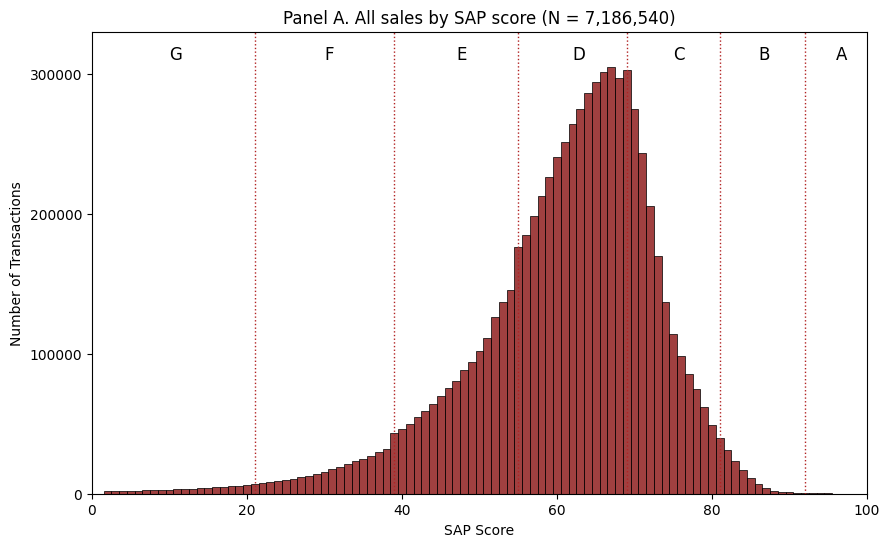

In [ ]:
# Create histogram for 'energy_sap_rating' with custom bin edges and styling
plt.figure(figsize=(10, 6))
sns.histplot(data['energy_sap_rating'], bins=[21, 39, 55, 69, 81, 92, 100], kde=False, discrete=True, color='maroon')

# Customize the x-axis and y-axis labels
plt.xlabel('SAP Score')
plt.ylabel('Number of Transactions')

# Customize the y-axis range and labels
plt.ylim(0, 330000)
plt.yticks([0, 100000, 200000, 300000], ['0', '100000', '200000', '300000'])

bin_edges = [1, 21, 39, 55, 69, 81, 92, 100]
for edge in bin_edges[1:-1]:  # Skip the first and last edges to avoid outside the range
    plt.axvline(x=edge, color='firebrick', linestyle=':', linewidth=1)

# Add a title
plt.title('Panel A. All sales by SAP score (N = 7,186,540)')
plt.xlim(0, 100)

# Add text annotations for the ratings
rating_labels = ["G", "F", "E", "D", "C", "B", "A"]
rating_positions = [320000, 320000, 320000, 320000, 320000, 320000, 320000]
x_positions = [10, 30, 47, 62, 75, 86, 96]
y_pos = 310000  # Adjust this value as needed
for label, y, x_pos in zip(rating_labels, rating_positions, x_positions):
    plt.text(x_pos, y_pos, label, color='black', fontsize=12)
# Show the plot
plt.show()


 ### Figure 2B

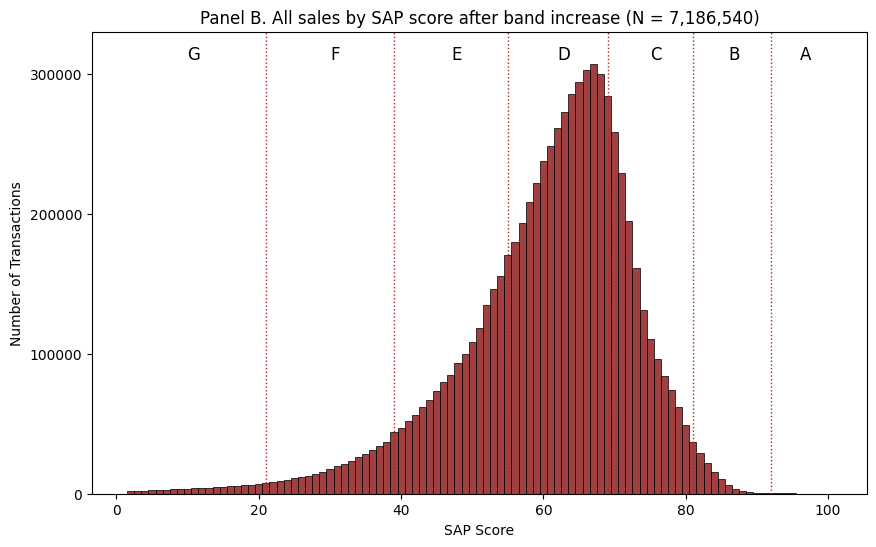

In [ ]:
# Create a temporary modified version of 'energy_sap_rating' without changing the original data
modified_data = data.copy()

# Replace 'energy_sap_rating' with 'starting_energy_sap_rating' where the condition is met
modified_data['energy_sap_rating'] = modified_data['starting_energy_sap_rating'].where(modified_data['energy_rating_band_increased'], modified_data['energy_sap_rating'])

# Create histogram for modified 'energy_sap_rating' with custom bin edges and styling
plt.figure(figsize=(10, 6))
sns.histplot(modified_data['energy_sap_rating'], bins=[21, 39, 55, 69, 81, 92, 100], kde=False, discrete=True, color='maroon')

# Customize the x-axis and y-axis labels
plt.xlabel('SAP Score')
plt.ylabel('Number of Transactions')

# Customize the y-axis range and labels
plt.ylim(0, 330000)
plt.yticks([0, 100000, 200000, 300000], ['0', '100000', '200000', '300000'])

# Add vertical dashed lines at the bin edges
bin_edges = [1, 21, 39, 55, 69, 81, 92, 100]
for edge in bin_edges[1:-1]:  # Skip the first and last edges to avoid outside the range
    plt.axvline(x=edge, color='firebrick', linestyle=':', linewidth=1)

# Add a title for Figure 2B
plt.title('Panel B. All sales by SAP score after band increase (N = 7,186,540)')

# Add text annotations for the ratings
rating_labels = ["G", "F", "E", "D", "C", "B", "A"]
rating_positions = [320000, 320000, 320000, 320000, 320000, 320000, 320000]
x_positions = [10, 30, 47, 62, 75, 86, 96]
y_pos = 310000  # Adjust this value as needed
for label, y, x_pos in zip(rating_labels, rating_positions, x_positions):
    plt.text(x_pos, y_pos, label, color='black', fontsize=12)

# Show the plot
plt.show()


### Figure 2C

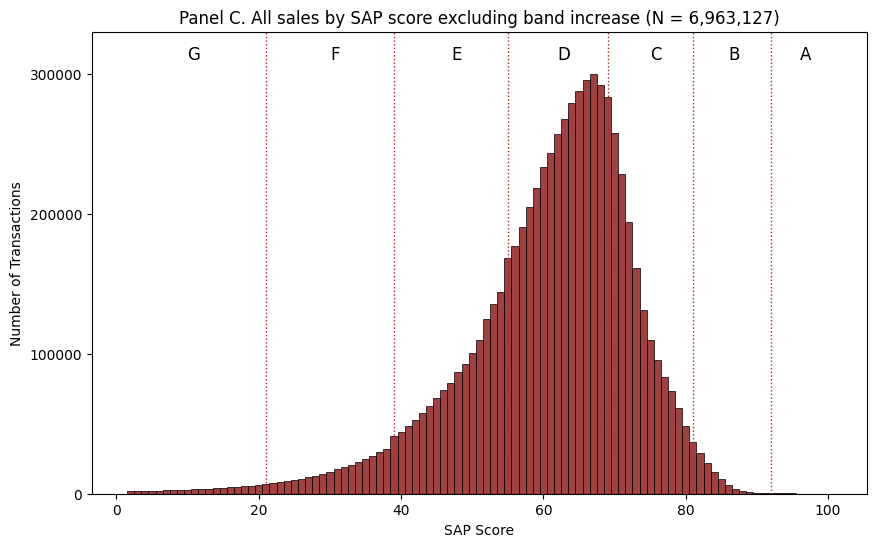

In [ ]:
# Create a temporary modified version of 'data' to drop rows with 'energy_rating_band_increased' == True
modified_data = data.copy()

# Drop rows where 'energy_rating_band_increased' is True
modified_data = modified_data[~modified_data['energy_rating_band_increased']]

# Create histogram for 'energy_sap_rating' with custom bin edges and styling
plt.figure(figsize=(10, 6))
sns.histplot(modified_data['energy_sap_rating'], bins=[21, 39, 55, 69, 81, 92, 100], kde=False, discrete=True, color='maroon')

# Customize the x-axis and y-axis labels
plt.xlabel('SAP Score')
plt.ylabel('Number of Transactions')

# Customize the y-axis range and labels
plt.ylim(0, 330000)
plt.yticks([0, 100000, 200000, 300000], ['0', '100000', '200000', '300000'])

# Add vertical dashed lines at the bin edges
bin_edges = [1, 21, 39, 55, 69, 81, 92, 100]
for edge in bin_edges[1:-1]:  # Skip the first and last edges to avoid outside the range
    plt.axvline(x=edge, color='firebrick', linestyle=':', linewidth=1)

# Add a title for Figure 2C
plt.title('Panel C. All sales by SAP score excluding band increase (N = 6,963,127)')

# Add text annotations for the ratings
rating_labels = ["G", "F", "E", "D", "C", "B", "A"]
rating_positions = [320000, 320000, 320000, 320000, 320000, 320000, 320000]
x_positions = [10, 30, 47, 62, 75, 86, 96]
y_pos = 310000  # Adjust this value as needed
for label, y, x_pos in zip(rating_labels, rating_positions, x_positions):
    plt.text(x_pos, y_pos, label, color='black', fontsize=12)

# Show the plot
plt.show()


### Figure 3

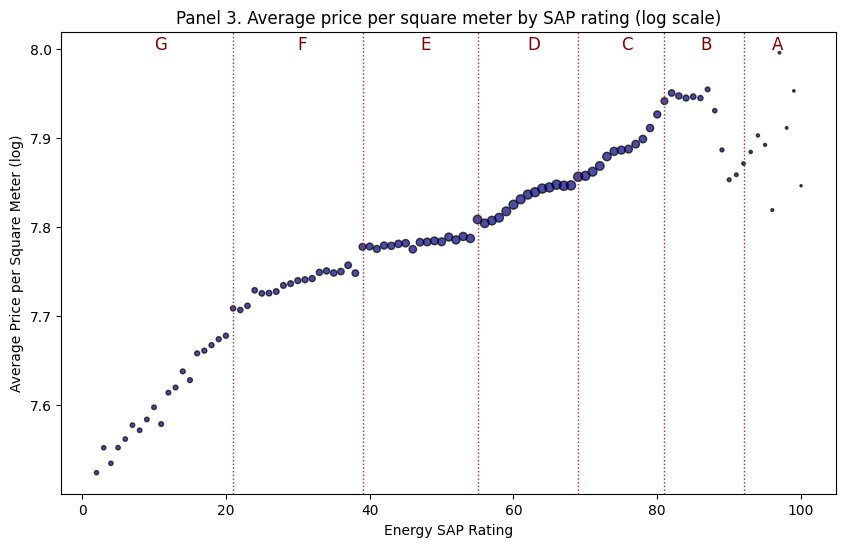

In [ ]:
# Drop rows where 'energy_rating_band_increased' is True
modified_data = data.copy()
modified_data = modified_data[~modified_data['energy_rating_band_increased']]

# Calculate mean price_per_meter_log and count for each energy_sap_rating
collapsed_data = modified_data.groupby('energy_sap_rating').agg(
    mean_price=('price_per_meter_log', 'mean'),
    freq=('price_per_meter_log', 'size')
).reset_index()

alpha = 0.3 #modify teh alpha param to scale teh scatter dots with alpha = 0.5 == sqrt the dots are too big!!!
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(collapsed_data['energy_sap_rating'], collapsed_data['mean_price'],
            s=collapsed_data['freq']**alpha, color='navy', edgecolors='black', alpha=0.7)  # Size by frequency

# Customize the x-axis and y-axis labels
plt.xlabel('Energy SAP Rating')
plt.ylabel('Average Price per Square Meter (log)')

# Add vertical dashed lines for bin edges
bin_edges = [21, 39, 55, 69, 81, 92]
for edge in bin_edges:
    plt.axvline(x=edge, color='firebrick', linestyle=':', linewidth=1)

# Add text annotations for the ratings
rating_labels = ["G", "F", "E", "D", "C", "B", "A"]
rating_positions = [10, 30, 47, 62, 75, 86, 96]
y_pos = 8

for label, x_pos in zip(rating_labels, rating_positions):
    plt.text(x_pos, y_pos, label, color='maroon', fontsize=12)

# Add a title
plt.title('Panel 3. Average price per square meter by SAP rating (log scale)')

# Show the plot
plt.show()


### Figure 4

Crashes!

### Figure 5

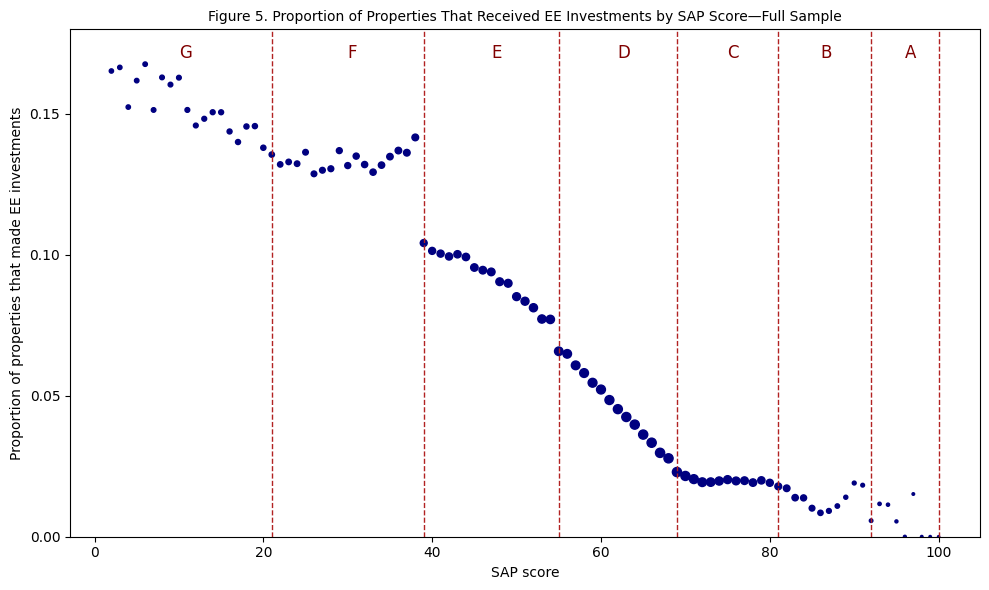

In [ ]:
# Group by SAP rating, compute mean and count
collapsed_data = data.groupby('starting_energy_sap_rating').agg(
    mean=('EE_investments', 'mean'),
    freq=('EE_investments', 'size')
).reset_index()

# Start plotting
plt.figure(figsize=(10, 6))
plt.scatter(
    collapsed_data['starting_energy_sap_rating'],
    collapsed_data['mean'],
    s=collapsed_data['freq']**alpha,  # fixed size, similar to `msize(vtiny)` in Stata
    color='navy'
)

# Vertical dashed lines for SAP bands
bin_edges = [21, 39, 55, 69, 81, 92, 100]
for edge in bin_edges:
    plt.axvline(x=edge, color='firebrick', linestyle='--', linewidth=1)

# Add band labels
rating_labels = ["G", "F", "E", "D", "C", "B", "A"]
rating_positions = [10, 30, 47, 62, 75, 86, 96]
for label, x_pos in zip(rating_labels, rating_positions):
    plt.text(x_pos, 0.17, label, color='maroon', fontsize=12)

# Customize axes
plt.xlabel("SAP score")
plt.ylabel("Proportion of properties that made EE investments")
plt.ylim(0, 0.18)
plt.yticks([0, 0.05, 0.1, 0.15])



# Add a title similar to the paper's figure title
plt.title("Figure 5. Proportion of Properties That Received EE Investments by SAP Score—Full Sample", fontsize=10)

plt.tight_layout()
plt.show()


### Figure 7

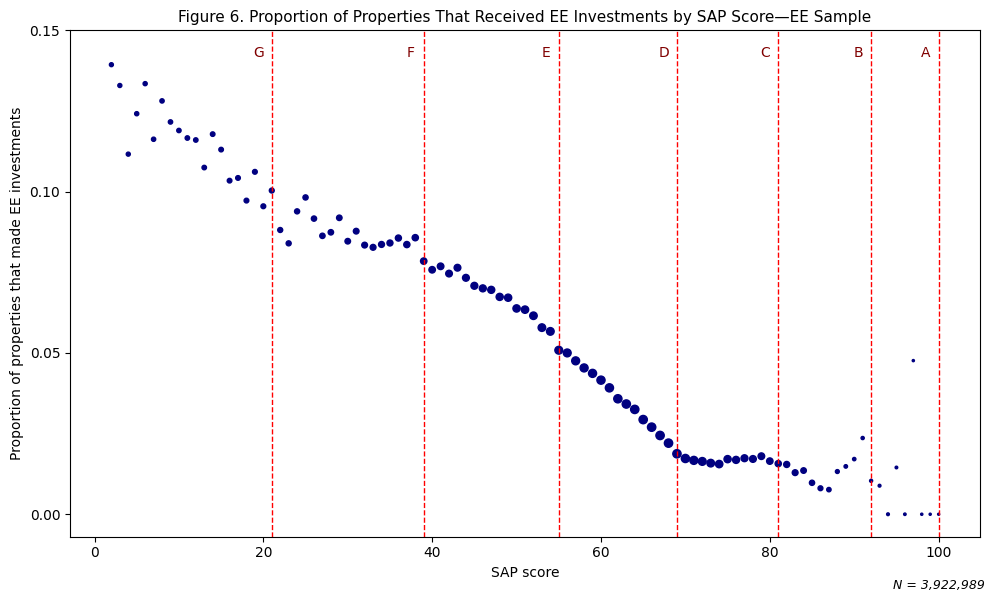

In [ ]:
# Assume daee is your pandas DataFrame
collapsed = (
    daee
    .groupby('starting_energy_sap_rating')
    .agg(mean=('EE_investments', 'mean'), freq=('EE_investments', 'count'))
    .reset_index()
)

# Normalize or scale dot sizes (adjust scale factor as needed)
point_sizes = np.sqrt(collapsed['freq']) * 1.5  # or try *0.05

# Define EPC thresholds
epc_thresholds = [21, 39, 55, 69, 81, 92, 100]
epc_labels = ['G', 'F', 'E', 'D', 'C', 'B', 'A']

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    collapsed['starting_energy_sap_rating'],
    collapsed['mean'],
    s=collapsed['freq']**alpha,
    color='navy'
)

# Add vertical lines for EPC bands
for thresh in epc_thresholds:
    plt.axvline(x=thresh, color='red', linestyle='--', linewidth=1)

# Add EPC text labels at top
for label, x in zip(epc_labels, epc_thresholds):
    plt.text(x - 1.5, 0.145, label, color='maroon', ha='center', va='top', fontsize=10)

# Format axes
plt.xlabel('SAP score')
plt.ylabel('Proportion of properties that made EE investments')
plt.yticks(np.arange(0, 0.18, 0.05))

plt.title('Figure 6. Proportion of Properties That Received EE Investments by SAP Score—EE Sample', fontsize=11)

# Optional: annotate N
n = daee.shape[0]
plt.figtext(0.99, 0.01, f'N = {n:,}', ha='right', fontsize=9, style='italic')

plt.tight_layout()
plt.show()


### Figure 7 & 8

crashes

### Figure 9

In [ ]:
true_data_EE = data[data['EE_investments'] == True]
print(len(true_data_EE))

375092


<ipython-input-23-7c37811059dd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


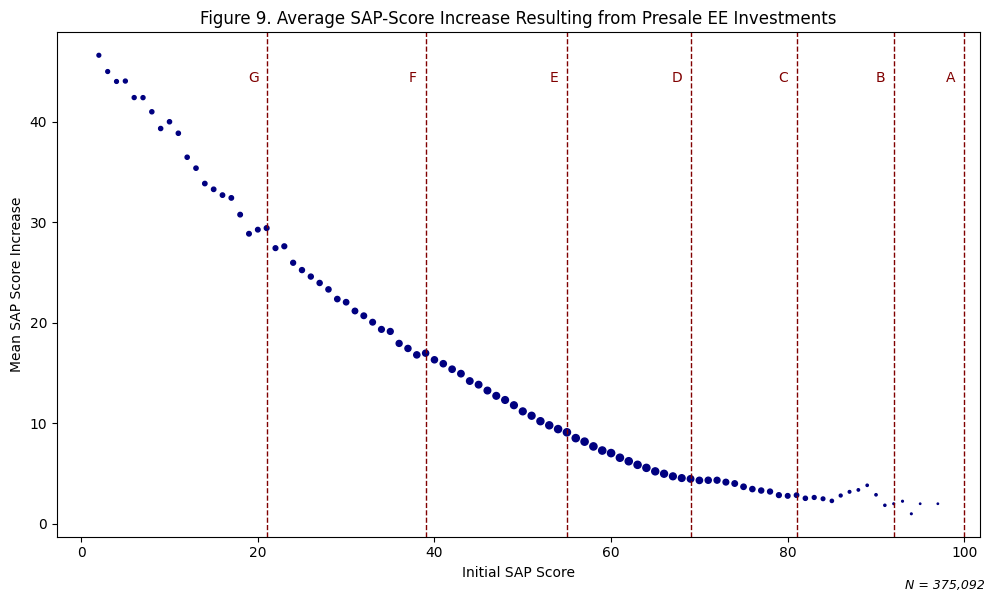

In [ ]:
true_data_EE = data[data['EE_investments'] == True]

# Calculate sizechangeSAP (energy_sap_rating - prev_energy_sap_rating)
true_data_EE['sizechangeSAP'] = true_data_EE['energy_sap_rating'] - true_data_EE['prev_energy_sap_rating']

# Collapse data: Calculate mean and count of sizechangeSAP grouped by starting_energy_sap_rating
collapsed = (
    true_data_EE
    .groupby('starting_energy_sap_rating')
    .agg(mean=('sizechangeSAP', 'mean'), freq=('sizechangeSAP', 'count'))
    .reset_index()
)

# Optional: summary of price for debugging or review
# print(data_copy['price'].describe())

# Normalize or scale dot sizes (adjust scale factor as needed)
point_sizes = np.sqrt(collapsed['freq']) * 1.5  # or try *0.05

# Define EPC thresholds
epc_thresholds = [21, 39, 55, 69, 81, 92, 100]
epc_labels = ['G', 'F', 'E', 'D', 'C', 'B', 'A']

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    collapsed['starting_energy_sap_rating'],
    collapsed['mean'],
    s=collapsed['freq']**0.35,  # Adjust point size scaling factor as needed
    color='navy'
)

# Add vertical lines for EPC bands
for thresh in epc_thresholds:
    plt.axvline(x=thresh, color='maroon', linestyle='--', linewidth=1)

# Add EPC text labels at top
for label, x in zip(epc_labels, epc_thresholds):
    plt.text(x - 1.5, 45, label, color='maroon', ha='center', va='top', fontsize=10)

# Format axes
plt.xlabel('Initial SAP Score')
plt.ylabel('Mean SAP Score Increase')


plt.title('Figure 9. Average SAP-Score Increase Resulting from Presale EE Investments', fontsize=12)

# Optional: annotate N
n = true_data_EE.shape[0]
plt.figtext(0.99, 0.01, f'N = {n:,}', ha='right', fontsize=9, style='italic')

plt.tight_layout()
plt.show()


### Table 1

#### Displayed in the paper

In [ ]:
# Format and summary statistics (like Stata's tabstat)
summary_vars = ['price', 'price_per_meter', 'total_floor_area', 'number_habitable_rooms', 'energy_sap_rating']
summary = data[summary_vars].describe(percentiles=[0.5]).T[['mean', '50%', 'std', 'min', 'max']]
summary.columns = ['Mean', 'Median', 'SD', 'Min', 'Max']
# Rename variables for display
var_name_map = {
    'price': 'Price Paid £',
    'price_per_meter': 'Price per square meter (£/sqm)',
    'total_floor_area': 'Total floor area (sqm)',
    'number_habitable_rooms': 'Number of rooms',
    'energy_sap_rating': 'SAP Score'
}

summary = summary.rename(index=var_name_map)

# Summary by energy_rating_band
summary_by_band = data.groupby('energy_rating_band')['price_per_meter'].describe(percentiles=[0.5])[
    ['mean', '50%', 'std', 'min', 'max']]
summary_by_band.columns = ['Mean', 'Median', 'SD', 'Min', 'Max']


# Concatenate vertically
combined_summary = pd.concat([summary, summary_by_band], axis=0)
# Optional: reorder columns
combined_summary = combined_summary[['Mean', 'Median', 'SD', 'Min', 'Max']]
combined_summary.round(0)


,Mean,Median,SD,Min,Max
Price Paid £,281891.0,215000.0,309425.0,1000.0,46131500.0
Price per square meter (£/sqm),2959.0,2506.0,2046.0,4.0,275331.0
Total floor area (sqm),95.0,84.0,47.0,30.0,8811.0
Number of rooms,5.0,5.0,2.0,1.0,112.0
SAP Score,61.0,63.0,12.0,2.0,100.0
G,2602.0,2100.0,2213.0,6.0,133721.0
F,2818.0,2339.0,2226.0,15.0,210556.0
E,2907.0,2409.0,2179.0,4.0,275331.0
D,2946.0,2513.0,1954.0,8.0,205128.0
C,3035.0,2588.0,2052.0,7.0,212766.0


In [ ]:
# Sample sizes
print("N total:", data['price_per_meter'].count())
print("N if energy_rating_band_increased == 0:", data.loc[data['energy_rating_band_increased'] == 0, 'price_per_meter'].count())
print("N EE investments sample:", daee['EE_investments'].count())

N total: 7186540
N if energy_rating_band_increased == 0: 6963127
N EE investments sample: 3922989


#### Extras present in the code

In [ ]:
# total_floor_area by band
floor_area_by_band = data.groupby('energy_rating_band')['total_floor_area'].describe(percentiles=[0.5])[
    ['mean', '50%', 'std', 'min', 'max']]
floor_area_by_band

,mean,50%,std,min,max
energy_rating_band,,,,,
G,97.407008,84.00,54.833634,30.0,2141.00
F,107.742364,91.00,61.803122,30.0,2957.00
E,101.147879,89.00,49.678430,30.0,5125.35
D,93.461801,84.38,41.688795,30.0,6886.10
C,90.862381,80.00,50.712329,30.0,8811.00
B,79.751187,65.90,63.016868,30.0,4498.00
A,105.903393,87.00,57.178276,33.0,596.00


### Table 2

In [ ]:
#property type

property_type_dist = data['property_type'].value_counts(normalize=False).to_frame('Freq').assign(
    Percent=lambda df: df['Freq'] / df['Freq'].sum() * 100
)
property_type_dist


,Freq,Percent
property_type,,
Terraced,2308793,32.126628
Semi-detached,2148513,29.896348
Detached,1695186,23.588347
Flat,1034048,14.388677
Other,0,0.000000


In [ ]:
#leasehold

leasehold_dist = data['leasehold'].value_counts(normalize=False).to_frame('Freq').assign(
    Percent=lambda df: df['Freq'] / df['Freq'].sum() * 100
)
leasehold_dist

,Freq,Percent
leasehold,,
0,5789227,80.556527
1,1397313,19.443473


In [ ]:
#region

region_dist = data['region'].value_counts(normalize=False).to_frame('Freq').assign(
    Percent=lambda df: df['Freq'] / df['Freq'].sum() * 100
)
region_dist

,Freq,Percent
region,,
South East,1210178,16.839508
North West,928447,12.919249
East,822011,11.438203
South West,772333,10.746938
London,772285,10.746270
Yorkshire and The Humber,687938,9.572590
West Midlands,677799,9.431507
East Midlands,633004,8.808189
Wales,363370,5.056258


In [ ]:
#urban

urban_dist = data['urban'].value_counts(normalize=False).to_frame('Freq').assign(
    Percent=lambda df: df['Freq'] / df['Freq'].sum() * 100
)
urban_dist

,Freq,Percent
urban,,
1.0,5851010,81.416231
0.0,1335530,18.583769


In [ ]:
#year

sale_year_dist = data['sale_year'].value_counts(normalize=False).sort_index().to_frame('Freq').assign(
    Percent=lambda df: df['Freq'] / df['Freq'].sum() * 100
)
sale_year_dist


,Freq,Percent
sale_year,,
2012,275910,3.839261
2013,611380,8.507293
2014,730970,10.171376
2015,727638,10.125011
2016,719319,10.009253
2017,707657,9.846978
2018,692496,9.636014
2019,688165,9.575749
2020,615758,8.568212


In [ ]:
#energy rating

energy_rating_band_dist = data['energy_rating_band'].value_counts(normalize=False).sort_index().to_frame('Freq').assign(
    Percent=lambda df: df['Freq'] / df['Freq'].sum() * 100
)
energy_rating_band_dist


,Freq,Percent
energy_rating_band,,
G,65293,0.908546
F,301922,4.201215
E,1348289,18.761309
D,3512374,48.874340
C,1817905,25.295970
B,138819,1.931653
A,1938,0.026967


In [ ]:
#energy rating increase yes/no

energy_rating_band_increased_dist = data['energy_rating_band_increased'].value_counts(normalize=False).to_frame('Freq').assign(
    Percent=lambda df: df['Freq'] / df['Freq'].sum() * 100
)
energy_rating_band_increased_dist


,Freq,Percent
energy_rating_band_increased,,
False,6963127,96.89123
True,223413,3.10877


In [ ]:
print('Observations')
print(f'Full sample {data.shape[0]}')
print(f'Sample excluding transactions with rating band increases (for price analysis) {energy_rating_band_increased_dist.loc[False,"Freq"]}')
print(f'Sample excluding transactions after April 2018 (for investment analysis) {daee.shape[0]}')


Observations
Full sample 7186540
Sample excluding transactions with rating band increases (for price analysis) 6963127
Sample excluding transactions after April 2018 (for investment analysis) 3922989


### Table 3

#### G-F

In [ ]:
# Model 1: All sales no covariates
df = data.copy()

df = df[df['energy_sap_rating'] <= 38] #drop if over 38
df = df[df['energy_sap_rating'] >= 1] #drop if below 1
df = df[df['energy_rating_band_increased'] == False] #drop the true ones
threshold = 21

# Define outcome and running variable
outcome = df['price_per_meter_log']
running_var = df['energy_sap_rating']
resultGF1 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='mserd', vce='hc1', cluster=df['energy_sap_rating'])
resultGF1

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                364861
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations         65293     299568
Number of Unique Obs.             19         18
Number of Effective Obs.       16631      31631
Bandwidth Estimation           3.816      3.816
Bandwidth Bias                 6.997      6.997
rho (h/b)                      0.545      0.545

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.023    0.003    7.905   2.682e-15     [0.017, 0.029]
Robust     

In [ ]:
# Model 2: All sales no covariates with two different MSE-optimal bandwidth selectors
df = data.copy()

df = df[df['energy_sap_rating'] <= 38] #drop if over 38
df = df[df['energy_sap_rating'] >= 1] #drop if below 1
df = df[df['energy_rating_band_increased'] == False] #drop the true ones
threshold = 21

outcome = df['price_per_meter_log']
running_var = df['energy_sap_rating']
resultGF2 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='msetwo', vce='hc1', cluster=df['energy_sap_rating'])
resultGF2

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                364861
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   msetwo
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations         65293     299568
Number of Unique Obs.             19         18
Number of Effective Obs.       16631      76502
Bandwidth Estimation           3.489      7.198
Bandwidth Bias                 6.529     10.595
rho (h/b)                      0.534      0.679

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.024    0.002   10.063   8.036e-24     [0.019, 0.029]
Robust     

Model 3 to 6 -- Adding FE -- was run but it consumes more than 334GB of RAM.

--> The script crashes
--> I tried some random sampling the max sample fraction usable without crashing it is around 30%
--> With this fraction data are not enough to replicate the author's results

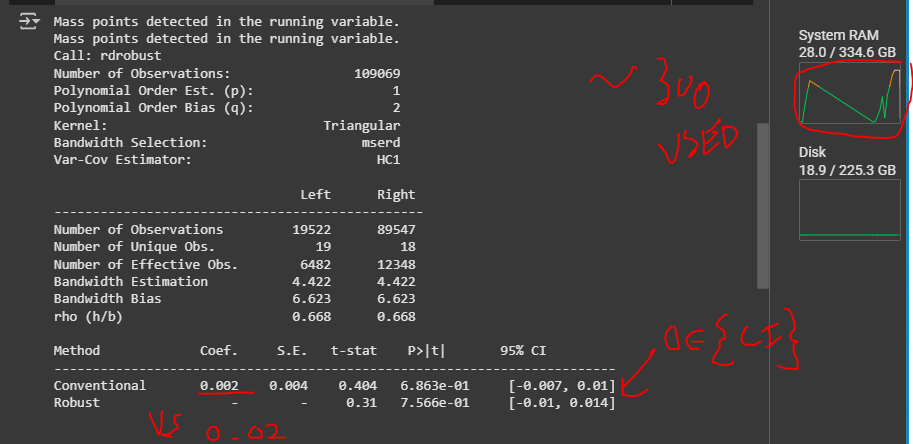

In [ ]:
# Model 2: Local linear regressions with property characteristics FE

df = data.copy()
df = df.sample(frac=0.3, random_state =42)
df = df[df['energy_sap_rating'] <= 38] #drop if over 38
df = df[df['energy_sap_rating'] >= 1] #drop if below 1
df = df[df['energy_rating_band_increased'] == False] #drop the true ones
threshold = 21

#create dummies
df = pd.get_dummies(df, columns=['property_type'], prefix='pt_', drop_first=False)
# Step 2: Filter necessary columns
df = df[['price_per_meter_log', 'energy_sap_rating'] + [col for col in df.columns if 'pt_' in col] + ['leasehold', 'number_habitable_rooms']]
covariates = df[[col for col in df.columns if col.startswith('pt_')] + ['leasehold', 'number_habitable_rooms']]

df = df.dropna()
covariates = covariates.dropna()
covariates = covariates.astype('int32')
# Step 3: Define outcome, running variable, and covariates
outcome = df['price_per_meter_log']
running_var = df['energy_sap_rating']


In [ ]:
resultGF3 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='mserd', vce='hc1', covs = covariates, cluster=running_var)
resultGF3

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                109069
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations         19522      89547
Number of Unique Obs.             19         18
Number of Effective Obs.        6482      12348
Bandwidth Estimation           4.422      4.422
Bandwidth Bias                 6.623      6.623
rho (h/b)                      0.668      0.668

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.002    0.004    0.404   6.863e-01     [-0.007, 0.01]
Robust     

#### F-E

In [ ]:
# Model 1&2
df = data.copy()

df = df[df['energy_sap_rating'] <= 54] #drop if over 38
df = df[df['energy_sap_rating'] >= 21] #drop if below 1
df = df[df['energy_rating_band_increased'] == False] #drop the true ones
threshold = 39
outcome = df['price_per_meter_log']
running_var = df['energy_sap_rating']

resultEF1 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='mserd', vce='hc1', cluster=df['energy_sap_rating'])
resultEF2 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='msetwo', vce='hc1', cluster=df['energy_sap_rating'])

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


In [ ]:
resultEF1

Call: rdrobust
Number of Observations:               1625431
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations        299568    1325863
Number of Unique Obs.             18         16
Number of Effective Obs.      113639     245331
Bandwidth Estimation           4.196      4.196
Bandwidth Bias                 6.807      6.807
rho (h/b)                      0.616      0.616

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.029    0.003     8.65   5.131e-18     [0.023, 0.036]
Robust                 -        -    7.253   4.063e-13     [0.024, 0.041]


In [ ]:
resultEF2

Call: rdrobust
Number of Observations:               1625431
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   msetwo
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations        299568    1325863
Number of Unique Obs.             18         16
Number of Effective Obs.      113639     376576
Bandwidth Estimation           4.283      6.481
Bandwidth Bias                 6.729      9.295
rho (h/b)                      0.636      0.697

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.028    0.004    8.044   8.700e-16     [0.021, 0.035]
Robust                 -        -    7.027   2.117e-12      [0.023, 0.04]


#### E-D

In [ ]:
# Model 1&2
df = data.copy()

df = df[df['energy_sap_rating'] <= 68] #drop if over 38
df = df[df['energy_sap_rating'] >= 39] #drop if below 1
df = df[df['energy_rating_band_increased'] == False] #drop the true ones
threshold = 55
outcome = df['price_per_meter_log']
running_var = df['energy_sap_rating']

resultDE1 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='mserd', vce='hc1', cluster=df['energy_sap_rating'])
resultDE2 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='msetwo', vce='hc1', cluster=df['energy_sap_rating'])

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


In [ ]:
resultDE1

Call: rdrobust
Number of Observations:               4739341
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations       1325863    3413478
Number of Unique Obs.             16         14
Number of Effective Obs.      404837     740804
Bandwidth Estimation            3.71       3.71
Bandwidth Bias                  5.47       5.47
rho (h/b)                      0.678      0.678

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.019    0.002    8.815   1.200e-18     [0.015, 0.024]
Robust                 -        -    8.314   9.270e-17     [0.017, 0.027]


In [ ]:
resultDE2

Call: rdrobust
Number of Observations:               4739341
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   msetwo
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations       1325863    3413478
Number of Unique Obs.             16         14
Number of Effective Obs.      404837     959199
Bandwidth Estimation           3.735      4.232
Bandwidth Bias                 6.662      5.159
rho (h/b)                      0.561       0.82

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.019    0.003    7.488   7.001e-14     [0.014, 0.024]
Robust                 -        -    9.901   4.122e-23     [0.017, 0.026]


#### D-C

In [ ]:
# Model 1&2
df = data.copy()

df = df[df['energy_sap_rating'] <= 80] #drop if over 38
df = df[df['energy_sap_rating'] >= 55] #drop if below 1
df = df[df['energy_rating_band_increased'] == False] #drop the true ones
threshold = 69
outcome = df['price_per_meter_log']
running_var = df['energy_sap_rating']

resultDC1 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='mserd', vce='hc1', cluster=df['energy_sap_rating'])
resultDC2 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='msetwo', vce='hc1', cluster=df['energy_sap_rating'])

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


In [ ]:
resultDC1

Call: rdrobust
Number of Observations:               5142136
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations       3413478    1728658
Number of Unique Obs.             14         12
Number of Effective Obs.      886646     964063
Bandwidth Estimation           3.799      3.799
Bandwidth Bias                 5.483      5.483
rho (h/b)                      0.693      0.693

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.009    0.001   10.254   1.134e-24     [0.008, 0.011]
Robust                 -        -    9.472   2.733e-21     [0.009, 0.014]


In [ ]:
resultDC2

Call: rdrobust
Number of Observations:               5142136
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   msetwo
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations       3413478    1728658
Number of Unique Obs.             14         12
Number of Effective Obs.     1174194    1125003
Bandwidth Estimation           4.169      4.036
Bandwidth Bias                  5.38      4.971
rho (h/b)                      0.775      0.812

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.009    0.001    8.612   7.158e-18     [0.007, 0.011]
Robust                 -        -    9.961   2.248e-23     [0.009, 0.014]


#### C-B

In [ ]:
# Model 1&2
df = data.copy()

df = df[df['energy_sap_rating'] <= 91] #drop if over 38
df = df[df['energy_sap_rating'] >= 69] #drop if below 1
df = df[df['energy_rating_band_increased'] == False] #drop the true ones
threshold = 81
outcome = df['price_per_meter_log']
running_var = df['energy_sap_rating']

resultCB1 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='mserd', vce='hc1', cluster=df['energy_sap_rating'])
resultCB2 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='msetwo', vce='hc1', cluster=df['energy_sap_rating'])

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


In [ ]:
resultCB1

Call: rdrobust
Number of Observations:               1857488
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations       1728658     128830
Number of Unique Obs.             12         11
Number of Effective Obs.      183120     103735
Bandwidth Estimation           3.686      3.686
Bandwidth Bias                 5.988      5.988
rho (h/b)                      0.616      0.616

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.003    0.002    1.367   1.715e-01    [-0.001, 0.007]
Robust                 -        -   -2.445   1.447e-02   [-0.007, -0.001]


In [ ]:
resultCB2

Call: rdrobust
Number of Observations:               1857488
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   msetwo
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations       1728658     128830
Number of Unique Obs.             12         11
Number of Effective Obs.      183120     124408
Bandwidth Estimation           3.475      6.812
Bandwidth Bias                 5.131      6.062
rho (h/b)                      0.677      1.124

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.004    0.003    1.322   1.863e-01    [-0.002, 0.009]
Robust                 -        -   -2.986   2.828e-03   [-0.007, -0.002]


#### B-A

In [ ]:
# Model 1&2
df = data.copy()

df = df[df['energy_sap_rating'] <= 100] #drop if over 38
df = df[df['energy_sap_rating'] >= 81] #drop if below 1
df = df[df['energy_rating_band_increased'] == False] #drop the true ones
threshold = 92
outcome = df['price_per_meter_log']
running_var = df['energy_sap_rating']

resultBA1 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='mserd', vce='hc1', cluster=df['energy_sap_rating'])
resultBA2 = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='msetwo', vce='hc1', cluster=df['energy_sap_rating'])

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


In [ ]:
resultBA1

Call: rdrobust
Number of Observations:                130267
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations        128830       1437
Number of Unique Obs.             11          9
Number of Effective Obs.        2561       1144
Bandwidth Estimation           3.143      3.143
Bandwidth Bias                 5.342      5.342
rho (h/b)                      0.588      0.588

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.019     0.01    2.012   4.420e-02     [0.001, 0.038]
Robust                 -        -    0.167   8.673e-01    [-0.027, 0.032]


In [ ]:
resultBA2

Call: rdrobust
Number of Observations:                130267
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   msetwo
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations        128830       1437
Number of Unique Obs.             11          9
Number of Effective Obs.        2561       1144
Bandwidth Estimation           3.357      3.651
Bandwidth Bias                 5.579       4.75
rho (h/b)                      0.602      0.769

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.026     0.01    2.516   1.188e-02     [0.006, 0.046]
Robust                 -        -    0.503   6.149e-01    [-0.021, 0.035]


#### Table 3 - Results

In [ ]:
# to be done :)

### Table 4 -- to finish other ranges but it works

#### G-F

In [ ]:
# Model 1: All sales no covariates
df = daee.copy()

df = df[df['energy_sap_rating'] <= 38] #drop if over 38
df = df[df['energy_sap_rating'] >= 1] #drop if below 1
threshold = 21
outcome = df['EE_investments']
running_var = df['energy_sap_rating']


resultGF1e = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='mserd', vce='hc1', cluster=df['energy_sap_rating'])
resultGF2e = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='msetwo', vce='hc1', cluster=df['energy_sap_rating'])


Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


In [ ]:
resultGF1e

Call: rdrobust
Number of Observations:                247657
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations         43674     203983
Number of Unique Obs.             19         18
Number of Effective Obs.       17116      34378
Bandwidth Estimation           5.968      5.968
Bandwidth Bias                 8.757      8.757
rho (h/b)                      0.681      0.681

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.002    0.006   -0.374   7.084e-01     [-0.015, 0.01]
Robust                 -        -    -0.38   7.037e-01     [-0.015, 0.01]


In [ ]:
resultGF2e

Call: rdrobust
Number of Observations:                247657
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   msetwo
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations         43674     203983
Number of Unique Obs.             19         18
Number of Effective Obs.       22559      34378
Bandwidth Estimation           7.604      5.483
Bandwidth Bias                10.709      7.667
rho (h/b)                       0.71      0.715

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.001    0.006   -0.142   8.872e-01    [-0.013, 0.011]
Robust                 -        -   -0.022   9.823e-01    [-0.012, 0.012]


#### D-C

In [ ]:
# Model 1: All sales no covariates
df = daee.copy()


df = df[df['energy_sap_rating'] <= 80] #drop if over 38
df = df[df['energy_sap_rating'] >= 55] #drop if below 1
threshold = 69
outcome = df['EE_investments']
running_var = df['energy_sap_rating']


resultDC1e = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='mserd', vce='hc1', cluster=df['energy_sap_rating'])
resultDC2e = rdrobust.rdrobust(outcome, running_var, c=threshold, kernel='triangular', bwselect='msetwo', vce='hc1', cluster=df['energy_sap_rating'])


Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


In [ ]:
resultDC1e

Call: rdrobust
Number of Observations:               2773618
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations       1876936     896682
Number of Unique Obs.             14         12
Number of Effective Obs.      908484     706590
Bandwidth Estimation           6.847      6.847
Bandwidth Bias                 5.925      5.925
rho (h/b)                      1.156      1.156

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.001      0.0   -3.074   2.114e-03     [-0.002, -0.0]
Robust                 -        -   -5.779   7.530e-09   [-0.002, -0.001]


In [ ]:
resultDC2e

Call: rdrobust
Number of Observations:               2773618
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   msetwo
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations       1876936     896682
Number of Unique Obs.             14         12
Number of Effective Obs.      460628     706590
Bandwidth Estimation           3.516      6.166
Bandwidth Bias                 8.334      5.691
rho (h/b)                      0.422      1.083

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.001      0.0   -3.836   1.249e-04   [-0.002, -0.001]
Robust                 -        -   -3.622   2.926e-04     [-0.001, -0.0]


### Table 5

In [ ]:
threshold = 21

In [ ]:
def run_price_density_test(data, threshold = 21, version='all'):
    """
    Replicates the Stata `price_rd` program logic for Table 5.

    Parameters:
        data (pd.DataFrame): original dataset
        threshold (int): the threshold for the RD (typically 21)
        version (str): one of ['all', 'replaced', 'no_upgrade']

    Returns:
        result: rdrobust result object
    """
    df = data.copy()

    #drop SAP = 1 or starting SAP = 1
    df = df[(df['energy_sap_rating'] != 1) & (df['starting_energy_sap_rating'] != 1)]

    if version == 'replaced':
        #replace current SAP with starting if rating band increased
        df.loc[df['energy_rating_band_increased'], 'energy_sap_rating'] = df.loc[df['energy_rating_band_increased'], 'starting_energy_sap_rating']

    elif version == 'no_upgrade':
        #exclude all rating band increases
        df = df[~df['energy_rating_band_increased']]

    #count frequency by energy_sap_rating
    freq_df = df.groupby('energy_sap_rating').agg(freq=('price_per_meter_log', 'count')).reset_index()

    #normalization and log
    total = len(df)
    freq_df['freq'] = freq_df['freq'] / total
    freq_df['freq_log'] = np.log(freq_df['freq'])

    #runRDD
    result = rdrobust.rdrobust(
        y=freq_df['freq_log'],
        x=freq_df['energy_sap_rating'],
        c=threshold,
        p=2,
        kernel='uniform',
        bwselect='mserd',
        vce='hc3'
    )

    return result


In [ ]:
#select the threshold by spefiying th eps value in the next cell

# GF --> 21
# FE --> 39
# ED --> 55
# DC --> 69
# CB --> 81
# BA --> 92

In [ ]:
eps = 55

In [ ]:
res_all = run_price_density_test(data, threshold = eps, version='all')
res_replaced = run_price_density_test(data, threshold = eps,version='replaced')
res_noupgrade = run_price_density_test(data, threshold = eps,version='no_upgrade')

print("All sales:\n", res_all)
print("\nReplaced SAP where upgraded:\n", res_replaced)
print("\nExclude upgrades:\n", res_noupgrade)


All sales:
 Call: rdrobust
Number of Observations:                    99
Polynomial Order Est. (p):                  2
Polynomial Order Bias (q):                  3
Kernel:                               Uniform
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC3

                                Left      Right
------------------------------------------------
Number of Observations            53         46
Number of Unique Obs.             53         46
Number of Effective Obs.          14         15
Bandwidth Estimation          14.687     14.687
Bandwidth Bias                20.128     20.128
rho (h/b)                       0.73       0.73

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.069    0.028     2.45   1.430e-02     [0.014, 0.124]
Robust                 -        -     1.99   4.664e-02     [0.001, 0.172]


Replaced SAP wh

### Table 6

#### Column 1: Donut-hole without covs

In [ ]:
#FOR BAND GF ...


df_rdd = data.copy()
#Exclude increases in energy rating bands
df_rdd = df_rdd[df_rdd['energy_rating_band_increased'] == 0]
#Restrict energy_sap_rating to <= 38 and drop 20, 21, 22 --> FGF BAND
df_rdd = df_rdd[df_rdd['energy_sap_rating'] <= 38]
df_rdd = df_rdd[~df_rdd['energy_sap_rating'].isin([20, 21, 22])]
#Create running and treatment variables
df_rdd['ee'] = df_rdd['energy_sap_rating'] - 21
df_rdd['d'] = (df_rdd['ee'] > 0).astype(int)
df_rdd['dxee'] = df_rdd['d'] * df_rdd['ee']

#OLS regression with clustering by `ee`
model = smf.ols('price_per_meter_log ~ d + ee + dxee', data=df_rdd)
results = model.fit(cov_type='cluster', cov_kwds={'groups': df_rdd['ee']})

print(results.summary())


                             OLS Regression Results                            
Dep. Variable:     price_per_meter_log   R-squared:                       0.006
Model:                             OLS   Adj. R-squared:                  0.006
Method:                  Least Squares   F-statistic:                     1116.
Date:                 Mon, 12 May 2025   Prob (F-statistic):           3.15e-33
Time:                         14:06:07   Log-Likelihood:            -3.3924e+05
No. Observations:               344409   AIC:                         6.785e+05
Df Residuals:                   344405   BIC:                         6.785e+05
Df Model:                            3                                         
Covariance Type:               cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6924      0.003   2445.50

In [ ]:
## FE....


df_fe = data.copy()
df_fe = df_fe[df_fe['energy_rating_band_increased'] == 0]
df_fe = df_fe[(df_fe['energy_sap_rating'] >= 21) & (df_fe['energy_sap_rating'] <= 54)]
df_fe = df_fe[~df_fe['energy_sap_rating'].isin([38, 39, 40])]

# Create RD variables
df_fe['ee'] = df_fe['energy_sap_rating'] - 39
df_fe['d'] = (df_fe['ee'] > 0).astype(int)
df_fe['dxee'] = df_fe['d'] * df_fe['ee']
df_fe['ee2'] = df_fe['ee'] ** 2
df_fe['dxee2'] = df_fe['d'] * df_fe['ee2']
df_fe['ee3'] = df_fe['ee'] ** 3
df_fe['dxee3'] = df_fe['d'] * df_fe['ee3']

# Run regression with clustering
model_fe = smf.ols('price_per_meter_log ~ d + ee + dxee', data=df_fe)
result_fe = model_fe.fit(cov_type='cluster', cov_kwds={'groups': df_fe['ee']})

print(result_fe.summary())


<ipython-input-123-6cf8351b3b31>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-123-6cf8351b3b31>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-123-6cf8351b3b31>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-123-6cf8351b3

                             OLS Regression Results                            
Dep. Variable:     price_per_meter_log   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     732.9
Date:                 Mon, 12 May 2025   Prob (F-statistic):           3.84e-28
Time:                         14:14:53   Log-Likelihood:            -1.4165e+06
No. Observations:              1507810   AIC:                         2.833e+06
Df Residuals:                  1507806   BIC:                         2.833e+06
Df Model:                            3                                         
Covariance Type:               cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7622      0.002   4599.49

NO NEED TO REPLICATE THEM ALL... IF WE NEED WE WILL BUT THE RESULTS ARE OK!

#### Column 2: Donut-hole with covs

In [ ]:
# from pg 45!!!

## Extension

### Actual Proposal





While Sejas-Portillo et al. (2025) provide suggestive evidence against strategic threshold gaming through descriptive statistics (e.g., smooth SAP improvements), they stop short of formally modeling the likelihood of minimal, threshold-targeted investments. My project proposes to define and estimate a model for 'strategic upgrades' — investments that just exceed a rating threshold — and to explore whether such behavior is more common in certain property types, locations, or sale periods.

**Research Question:**
Do property owners strategically make minimal energy efficiency investments just sufficient to cross EPC rating thresholds and capture price premiums?

**Hypothesis:**Sellers whose initial EPC score is just below a rating band threshold are more likely to:

- Make an investment --> done by the author
- Make an investment that just crosses the threshold, rather than exceeding it by a large margin (i.e., a strategic upgrade).

#### Preparing the Data

In [98]:
#first let's check again the data
data.columns

Index(['price', 'property_type', 'leasehold', 'postcode_area',
       'prev_sale_date', 'energy_sap_rating', 'co2_emissions_current',
       'co2_emiss_curr_per_floor_area', 'total_floor_area',
       'number_habitable_rooms', 'prev_energy_sap_rating', 'local_authority',
       'region', 'urban', 'sale_date', 'sale_year', 'sale_month',
       'sale_quarter', 'sale_year_quarter', 'epc_lodgement_date',
       'energy_rating_band', 'prev_energy_rating_band', 'price_per_meter',
       'price_per_meter_log', 'price_log', 'energy_rating_band_increased',
       'starting_energy_sap_rating', 'EE_investments'],
      dtype='object')

In [99]:
daee.columns

Index(['price', 'property_type', 'leasehold', 'postcode_area',
       'prev_sale_date', 'energy_sap_rating', 'co2_emissions_current',
       'co2_emiss_curr_per_floor_area', 'total_floor_area',
       'number_habitable_rooms', 'prev_energy_sap_rating', 'local_authority',
       'region', 'urban', 'sale_date', 'sale_year', 'sale_month',
       'sale_quarter', 'sale_year_quarter', 'epc_lodgement_date',
       'energy_rating_band', 'prev_energy_rating_band', 'price_per_meter',
       'price_log', 'energy_rating_band_increased',
       'starting_energy_sap_rating', 'EE_investments'],
      dtype='object')

In [100]:
daee.shape

(3922989, 27)

In [101]:
#keep only obs where an improvement occurred
df = daee.copy()
df = df[df.EE_investments == True]

In [102]:
df.shape

(161604, 27)

In [103]:
#drop columns we do not need
df = df[['price','price_log','property_type', 'leasehold', 'postcode_area',
       'prev_sale_date', 'energy_sap_rating', 'co2_emissions_current','total_floor_area',
       'number_habitable_rooms', 'prev_energy_sap_rating', 'local_authority',
       'region', 'urban','sale_year', 'sale_quarter',
       'energy_rating_band', 'prev_energy_rating_band',
       ]]

In [104]:
df

,price,price_log,property_type,leasehold,postcode_area,prev_sale_date,energy_sap_rating,co2_emissions_current,total_floor_area,number_habitable_rooms,prev_energy_sap_rating,local_authority,region,urban,sale_year,sale_quarter,energy_rating_band,prev_energy_rating_band
19,225000,12.323856,Semi-detached,0,BS,NaN,72.0,2.3,73.00,4.0,67.0,E06000023,South West,1.0,2017,1,C,D
46,260000,12.468437,Detached,0,BS,NaN,53.0,5.2,96.66,5.0,50.0,E06000023,South West,1.0,2016,4,E,E
126,155000,11.951180,Terraced,0,BS,NaN,67.0,3.3,85.00,5.0,52.0,E06000023,South West,1.0,2015,3,D,E
146,162500,11.998433,Semi-detached,0,BS,NaN,49.0,5.4,83.00,5.0,47.0,E06000023,South West,1.0,2015,3,E,E
202,244750,12.407993,Semi-detached,0,BS,NaN,62.0,3.8,89.00,5.0,60.0,E06000023,South West,1.0,2015,3,D,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7726322,220000,12.301383,Semi-detached,0,OL,NaN,87.0,1.5,105.00,7.0,82.0,E08000004,North West,1.0,2016,3,B,B
7726333,80000,11.289782,Flat,1,OL,NaN,64.0,2.6,60.53,3.0,58.0,E08000004,North West,1.0,2017,1,D,D
7726378,130000,11.775290,Terraced,0,OL,NaN,67.0,3.7,156.00,6.0,52.0,E08000004,North West,0.0,2013,3,D,E
7726411,200000,12.206073,Detached,1,OL,NaN,80.0,2.5,107.00,6.0,74.0,E08000004,North West,1.0,2016,3,C,C


In [105]:
#define the EPC band thresholds
thresholds = {
    'G-F': 21,
    'F-E': 39,
    'E-D': 55,
    'D-C': 69,
    'C-B': 81,
    'B-A': 92
}

window_before = 7
window_after = 4

#dictionary to store the band-specific DataFrames
data_band_dict = {}

#loop through each threshold and generate a cleaned DataFrame
for label, cutoff in thresholds.items():
    df_band = df.copy()

    #keep observations within [-5, 0) of the threshold
    mask_band_range = (
        (df_band['prev_energy_sap_rating'] >= cutoff - window_before) &
        (df_band['prev_energy_sap_rating'] < cutoff)
    )
    df_band = df_band[mask_band_range].copy()

    #strategic_upgrade if it just crosses the threshold but not by much
    df_band['strategic_upgrade'] = 0
    mask_strategic = (
        (df_band['energy_sap_rating'] >= cutoff) &
        (df_band['energy_sap_rating'] < cutoff + window_after)
    )
    df_band.loc[mask_strategic, 'strategic_upgrade'] = 1

    #distance from cutoff before improvement
    df_band['dist_to_threshold'] = cutoff - df_band['prev_energy_sap_rating']

    #energy_sap_rating_change
    df_band['energy_sap_rating_change'] = df_band['energy_sap_rating'] - df_band['prev_energy_sap_rating']

    #store the resulting DataFrame in the dictionary
    data_band_dict[label] = df_band

# Optional: Print the keys to confirm
print("Bands created:", list(data_band_dict.keys()))


Bands created: ['G-F', 'F-E', 'E-D', 'D-C', 'C-B', 'B-A']


In [106]:
data_band_dict['D-C'].strategic_upgrade.value_counts()

,count
strategic_upgrade,
0,18273
1,12404


#### Visualization

In [107]:
colors = {
    'G-F': '#F9665E',
    'F-E': '#FEC9C9',
    'E-D': '#EEF1E6',
    'D-C': '#AFC7D0',
    'C-B': '#95B4CC',
    'B-A': '#799FCB'
}

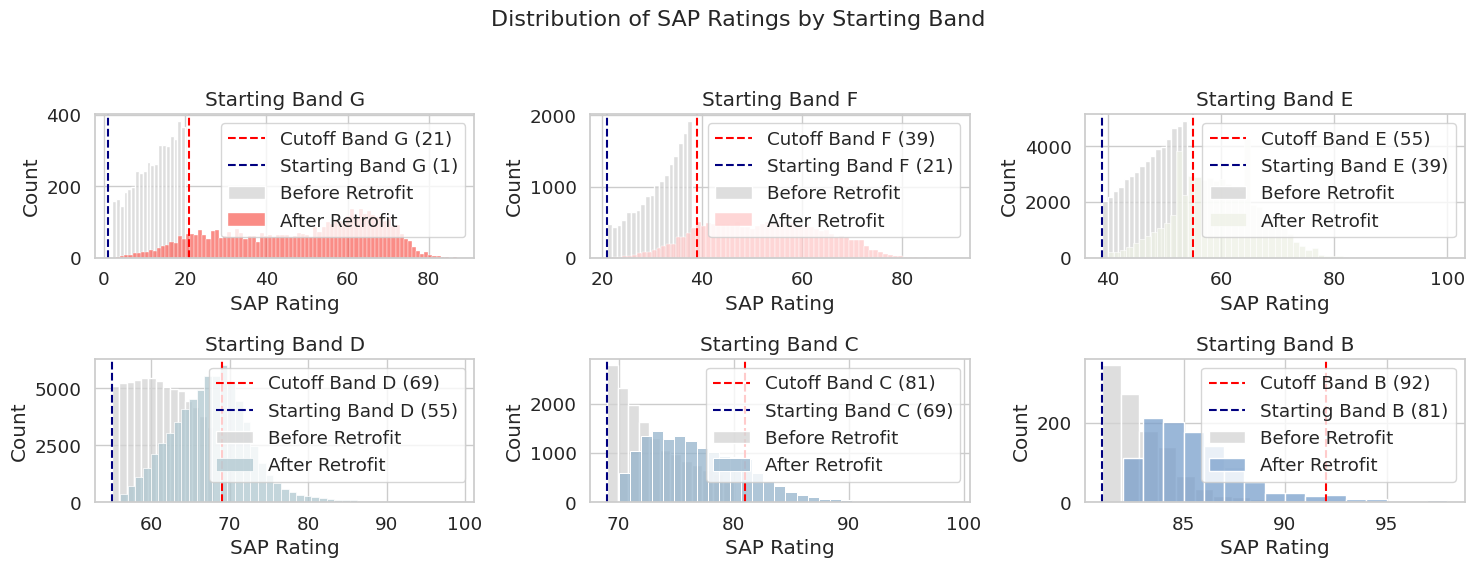

In [108]:
# Reverse the thresholds dictionary to map SAP rating to starting band
sap_to_band = {
    range(1, 21): 'G',
    range(21, 39): 'F',
    range(39, 55): 'E',
    range(55, 69): 'D',
    range(69, 81): 'C',
    range(81, 92): 'B',
    range(92, 101): 'A'
}

# Helper function to assign band
def get_band(sap):
    for r, band in sap_to_band.items():
        if sap in r:
            return band
    return None

# Assign starting band
df['starting_band'] = df['prev_energy_sap_rating'].apply(get_band)
colors_here = ['#F9665E','#FEC9C9','#EEF1E6','#AFC7D0','#95B4CC','#799FCB']

# Unique bands in order G → A
ordered_bands = ['G', 'F', 'E', 'D', 'C', 'B']
cutoffs = [21,39,55,69,81,92]
starting_band = [1,21,39,55,69,81]
i = 0
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 3 rows, 2 columns
fig.suptitle("Distribution of SAP Ratings by Starting Band", fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

i = 0
for band, ax in zip(ordered_bands, axes):
    df_band = df[df['starting_band'] == band]

    sns.histplot(df_band['prev_energy_sap_rating'], bins=df_band['prev_energy_sap_rating'].nunique(), color='lightgray', label='Before Retrofit', ax=ax)
    sns.histplot(df_band['energy_sap_rating'], bins=df_band['energy_sap_rating'].nunique(), color=colors_here[i], label='After Retrofit', ax=ax)
    ax.axvline(x=cutoffs[i], color='red', linestyle='--', label=f'Cutoff Band {band} ({cutoffs[i]})')
    ax.axvline(x=starting_band[i], color='navy', linestyle='--', label=f'Starting Band {band} ({starting_band[i]})')
    i = i+1
    ax.set_title(f"Starting Band {band}")
    ax.set_xlabel("SAP Rating")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
plt.show()

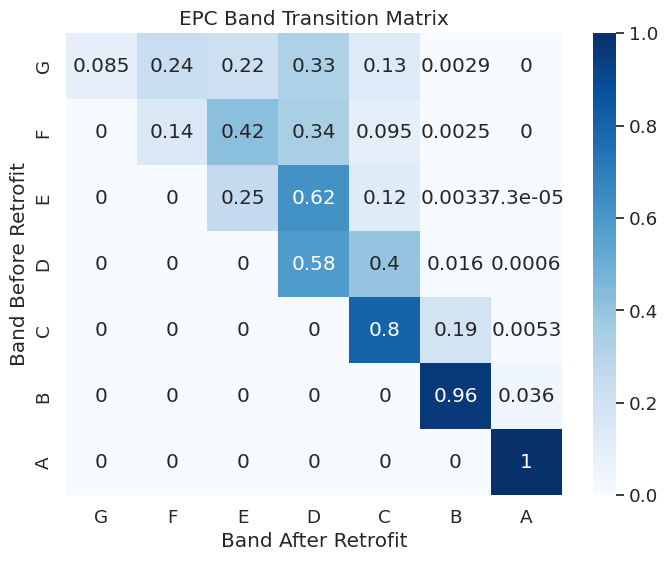

In [110]:
transition_matrix = pd.crosstab(df['prev_energy_rating_band'], df['energy_rating_band'], normalize='index')
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap='Blues')
plt.title("EPC Band Transition Matrix")
plt.xlabel("Band After Retrofit")
plt.ylabel("Band Before Retrofit")
plt.show()


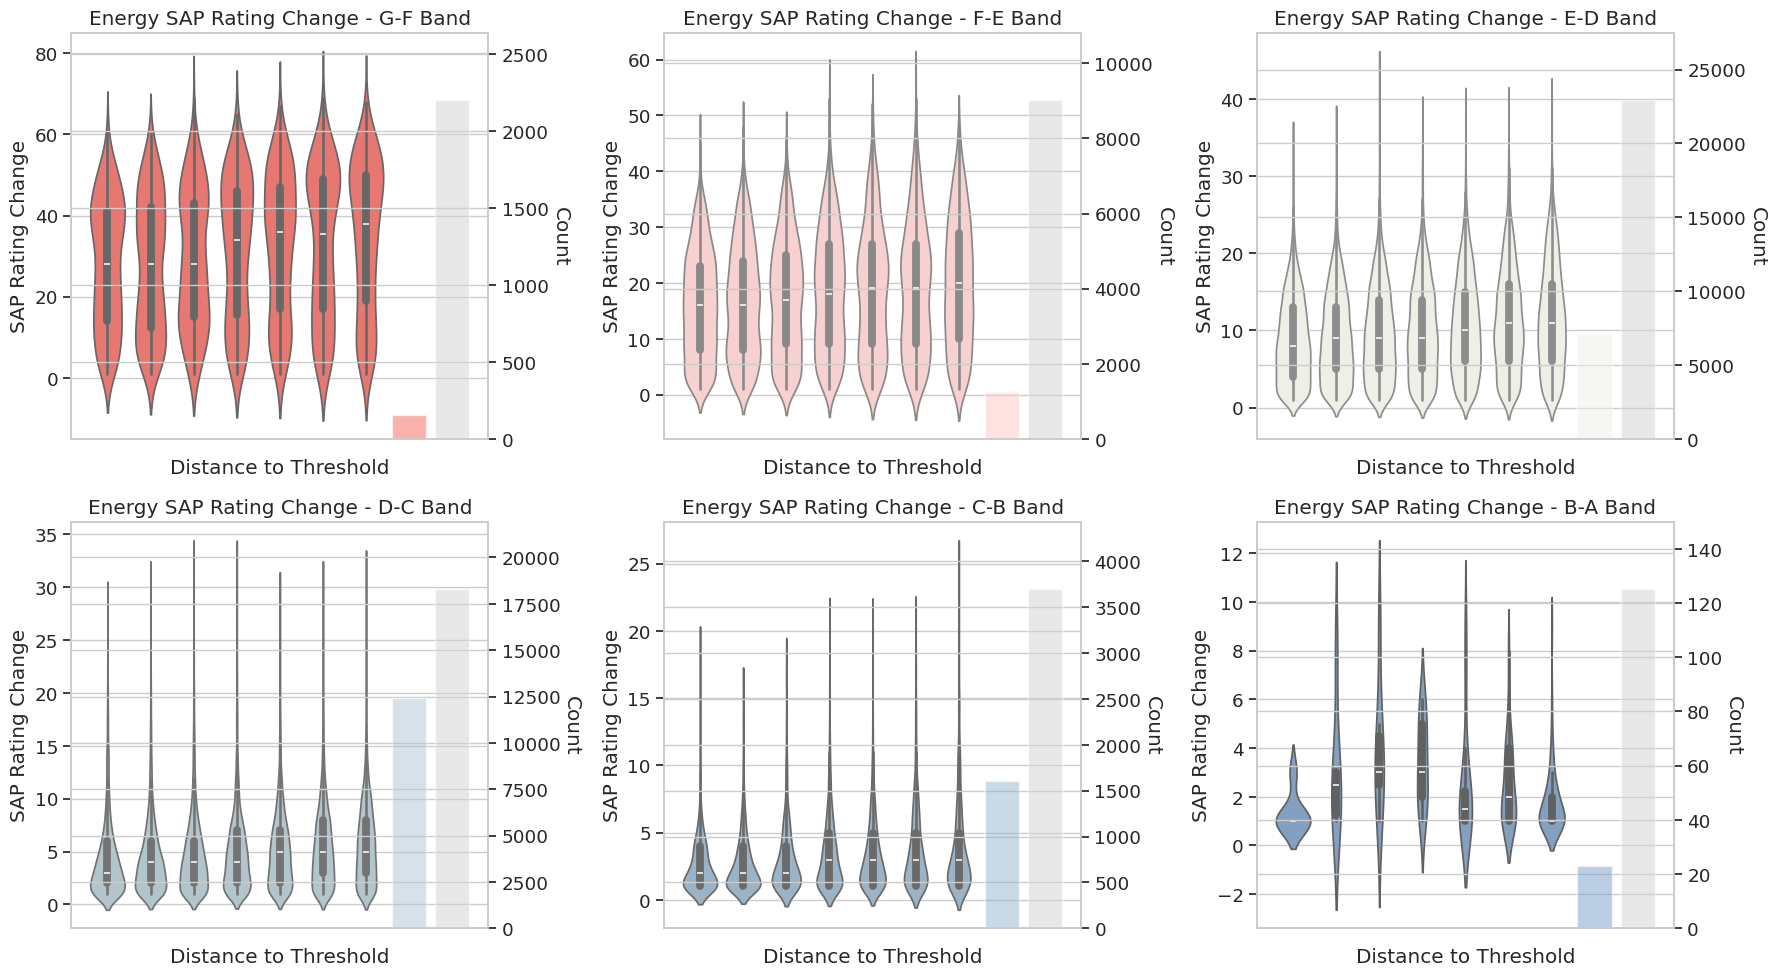

In [111]:
# Set up the 2x3 grid layout
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through bands and plot on the grid
for i, (band, df_band) in enumerate(data_band_dict.items()):
    # Compute share of strategic upgrades
    total = len(df_band)
    strategic_count = df_band['strategic_upgrade'].sum()
    share = strategic_count / total if total > 0 else 0
    non_strategic = total - strategic_count

    # Access the current subplot using axes[i]
    ax1, ax2 = axes[i], axes[i].twinx()  # Create a twin axis for the bar chart

    # Violin plot
    sns.violinplot(
        data=df_band,
        x='dist_to_threshold',
        y='energy_sap_rating_change',
        ax=ax1,
        color=colors[band]
    )
    ax1.set_title(f'Energy SAP Rating Change - {band} Band')
    ax1.set_xlabel('Distance to Threshold')
    ax1.set_ylabel('SAP Rating Change')

    # Bar plot (on twin axis)
    ax2.bar(
        ['Strategic', 'Not Strategic'],
        [strategic_count, non_strategic],
        color=[colors[band], 'lightgray'],
        alpha=0.5  # Adjust alpha for better visibility
    )
    ax2.set_ylabel('Count', rotation=270, labelpad=15)  # Rotate ylabel and adjust padding
    ax2.set_ylim(0, max(strategic_count, non_strategic) * 1.2)  # Adjust ylim for better spacing

    # Hide x-axis labels for the bar chart
    ax2.set_xticklabels([])

plt.tight_layout()
plt.show()

#### No covariates + Logit for robustness

In [34]:
# Initialize results dictionary
summary_results = []

for label, df_band in data_band_dict.items():
    # Drop missing values
    df_clean = df_band.dropna(subset=['strategic_upgrade', 'dist_to_threshold'])

    # Get metadata
    n_obs = len(df_clean)
    class_share = df_clean['strategic_upgrade'].mean()

    # === LPM ===
    lpm_model = smf.ols('strategic_upgrade ~ dist_to_threshold', data=df_clean).fit()

    # === Logit ===
    logit_model = smf.logit('strategic_upgrade ~ dist_to_threshold', data=df_clean).fit(disp=0)
    conf_int = lpm_model.conf_int(alpha=0.05)  # 95% confidence interval
    lower_ci = conf_int.loc['dist_to_threshold', 0]
    upper_ci = conf_int.loc['dist_to_threshold', 1]
    # Save results
    summary_results.append({
        'Band': label,
        'N_obs': n_obs,
        'Class_Share': class_share,
        'LPM_coef': lpm_model.params['dist_to_threshold'],
        'LPM_pval': lpm_model.pvalues['dist_to_threshold'],
        'Logit_coef (logodds)': logit_model.params['dist_to_threshold'],
        'Logit_coef (odds)': np.exp(logit_model.params['dist_to_threshold']),
        'Logit_pval': logit_model.pvalues['dist_to_threshold'],
        'LPM_lower_ci': lower_ci,
        'LPM_upper_ci': upper_ci})

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(summary_results)
results_df = results_df.sort_values('Band')
results_df


,Band,N_obs,Class_Share,LPM_coef,LPM_pval,Logit_coef (logodds),Logit_coef (odds),Logit_pval,LPM_lower_ci,LPM_upper_ci
5,B-A,148,0.155405,-0.136335,2.252289e-18,-1.032883,0.355979,2.509209e-08,-0.163159,-0.109511
4,C-B,5300,0.303208,-0.096475,7.670924e-208,-0.494277,0.610012,2.566629e-166,-0.102350,-0.090601
3,D-C,30677,0.404342,-0.061085,0.000000e+00,-0.261578,0.769836,0.000000e+00,-0.063808,-0.058361
2,E-D,30039,0.237058,-0.008668,2.063676e-12,-0.048160,0.952981,2.183871e-12,-0.011084,-0.006252
1,F-E,10257,0.121381,-0.002284,1.622122e-01,-0.021507,0.978722,1.622509e-01,-0.005487,0.000919
0,G-F,2359,0.066978,-0.001528,5.516726e-01,-0.024513,0.975785,5.515702e-01,-0.006561,0.003505


1. Linear Probability Model (LPM)
This is just an OLS regression with a binary dependent variable. The coefficient is interpreted directly as a change in probability:

✅ Interpretation:
A one-unit increase in dist_to_threshold is associated with a β-unit increase in the probability of a strategic upgrade.

Example:
If LPM_coef = -0.07, then:

A one-unit increase in dist_to_threshold is associated with a 7 percentage point decrease in the probability of a strategic upgrade

2. Logistic Regression (Logit)
This models the log-odds of the event (here, strategic upgrade = 1).

✅ Interpretation of coefficient:
A one-unit increase in dist_to_threshold changes the log-odds of a strategic upgrade by β.

To make this more intuitive, exponentiate the coefficient to interpret it as an odds ratio:

python
Copy
Edit
odds_ratio = np.exp(logit_model.params['dist_to_threshold'])
Example:
If Logit_coef = -0.65, then:

The odds of a strategic upgrade decrease by ~48% (exp(-0.65) ≈ 0.52) for each unit increase in dist_to_threshold.

#### Robustness + covariates

In [35]:
# Initialize results dictionary
summary_results_cov = []

for label, df_band in data_band_dict.items():
    # Drop missing values
    df_clean = df_band.dropna(subset=[
        'strategic_upgrade', 'dist_to_threshold', 'leasehold', 'co2_emissions_current',
        'total_floor_area', 'number_habitable_rooms', 'urban', 'sale_year', 'sale_quarter',
        'property_type', 'postcode_area', 'local_authority', 'region', 'prev_energy_rating_band'
    ])

    # Skip if not enough observations
    if len(df_clean) < 50:
        continue

    # Get metadata
    n_obs = len(df_clean)
    class_share = df_clean['strategic_upgrade'].mean()

    # === LPM ===
    formula = """
        strategic_upgrade ~ dist_to_threshold + leasehold +
        total_floor_area + number_habitable_rooms + urban +
        C(region)
    """
    lpm_model = smf.ols(formula=formula, data=df_clean).fit()
    conf_int = lpm_model.conf_int(alpha=0.05)  # 95% confidence interval
    lower_ci = conf_int.loc['dist_to_threshold', 0]
    upper_ci = conf_int.loc['dist_to_threshold', 1]
    # Save results
    summary_results_cov.append({
        'Band': label,
        'N_obs': n_obs,
        'Class_Share': class_share,
        'LPM_coef_cov': lpm_model.params['dist_to_threshold'],
        'LPM_pval_cov': lpm_model.pvalues['dist_to_threshold'],
        'LPM_lower_ci_cov': lower_ci,
        'LPM_upper_ci_cov': upper_ci})

# Convert to DataFrame for easy viewing
results_df_cov = pd.DataFrame(summary_results_cov)
results_df_cov = results_df_cov.sort_values('Band')
results_df_cov


,Band,N_obs,Class_Share,LPM_coef_cov,LPM_pval_cov,LPM_lower_ci_cov,LPM_upper_ci_cov
5,B-A,147,0.149660,-0.144395,4.708053e-16,-0.175215,-0.113575
4,C-B,5255,0.302569,-0.092474,3.166049e-190,-0.098384,-0.086565
3,D-C,30644,0.404484,-0.062024,0.000000e+00,-0.064748,-0.059301
2,E-D,30025,0.237102,-0.008695,1.799099e-12,-0.011112,-0.006278
1,F-E,10244,0.121535,-0.002524,1.237144e-01,-0.005738,0.000690
0,G-F,2356,0.067063,-0.001579,5.394356e-01,-0.006623,0.003465


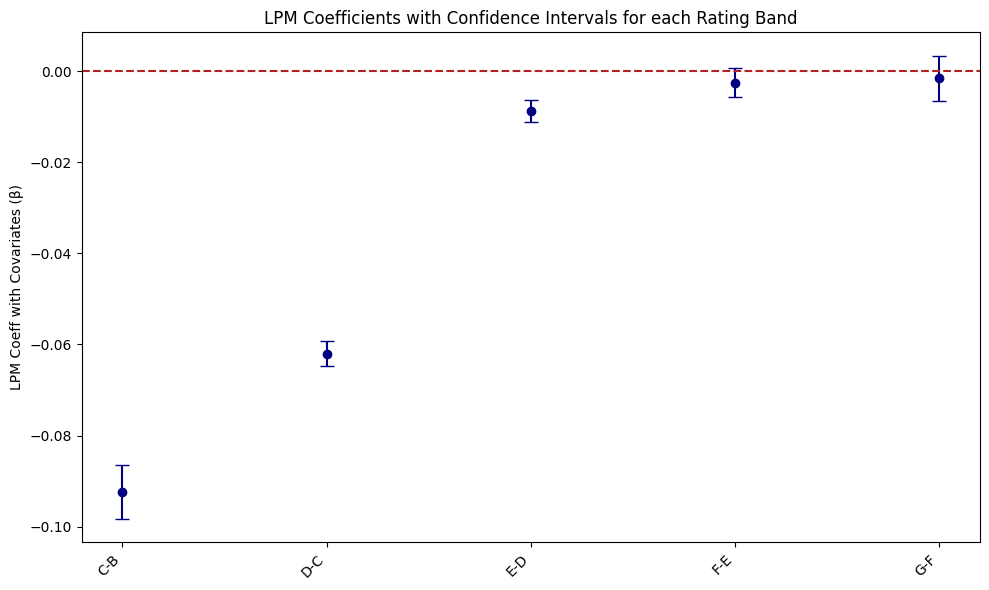

In [36]:
# Create the plot
results_df_cov = results_df_cov[results_df_cov['Band'] != 'B-A']

plt.figure(figsize=(10, 6))
plt.errorbar(
    x=results_df_cov['Band'],
    y=results_df_cov['LPM_coef_cov'],
    yerr=[
        results_df_cov['LPM_coef_cov'] - results_df_cov['LPM_lower_ci_cov'],
        results_df_cov['LPM_upper_ci_cov'] - results_df_cov['LPM_coef_cov']
    ],
    fmt='o',  # Use circles for markers
    capsize=5,  # Add caps to the error bars
    color='navy'
)

# Add a horizontal line at y=0
plt.axhline(y=0, color='firebrick', linestyle='--')

# Customize the plot
plt.ylabel('LPM Coeff with Covariates (β)')
plt.title('LPM Coefficients with Confidence Intervals for each Rating Band')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

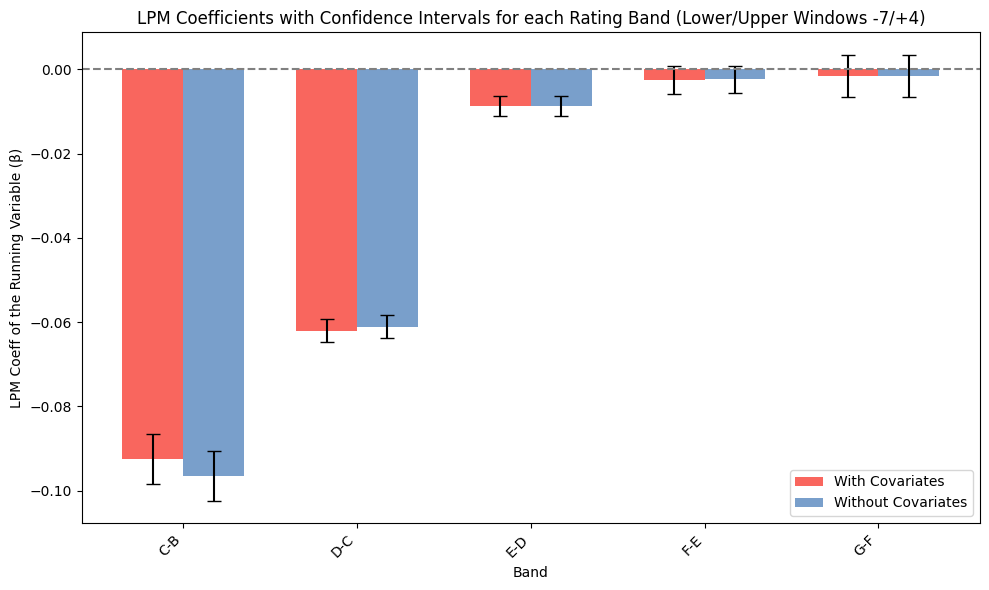

In [37]:
# Filter out the "B-A" band from both DataFrames
filtered_df_cov = results_df_cov[results_df_cov['Band'] != 'B-A']
filtered_df = results_df[results_df['Band'] != 'B-A']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot with covariates
width = 0.35  # Width of the bars
x = np.arange(len(filtered_df_cov['Band']))  # X positions for the bars

ax.bar(
    x - width / 2,
    filtered_df_cov['LPM_coef_cov'],
    width,
    yerr=[
        filtered_df_cov['LPM_coef_cov'] - filtered_df_cov['LPM_lower_ci_cov'],
        filtered_df_cov['LPM_upper_ci_cov'] - filtered_df_cov['LPM_coef_cov']
    ],
    capsize=5,
    color=colors['G-F'],
    label='With Covariates'
)

# Bar plot without covariates
ax.bar(
    x + width / 2,
    filtered_df['LPM_coef'],
    width,
    yerr=[
        filtered_df['LPM_coef'] - filtered_df['LPM_lower_ci'],
        filtered_df['LPM_upper_ci'] - filtered_df['LPM_coef']
    ],
    capsize=5,
    color=colors['B-A'],
    label='Without Covariates'
)

# Add a horizontal line at y=0
ax.axhline(y=0, color='gray', linestyle='--')

# Customize the plot
ax.set_xlabel('Band')
ax.set_ylabel('LPM Coeff of the Running Variable (β)')
ax.set_title('LPM Coefficients with Confidence Intervals for each Rating Band (Lower/Upper Windows -7/+4)')

# Set x-axis tick positions and labels
ax.set_xticks(x)
ax.set_xticklabels(filtered_df_cov['Band'], rotation=45, ha='right')

# Add a legend
ax.legend()

plt.tight_layout()
plt.show()

#### Het. Analysis

##### Heterogeneity - Property type

In [46]:
# Initialize results dictionary
summary_results_cov = []

for label, df_band in data_band_dict.items():
    # Drop missing values
    df_clean = df_band.dropna(subset=[
        'strategic_upgrade', 'dist_to_threshold', 'leasehold', 'co2_emissions_current',
        'total_floor_area', 'number_habitable_rooms', 'urban', 'sale_year', 'sale_quarter',
        'property_type', 'postcode_area', 'local_authority', 'region', 'prev_energy_rating_band'
    ])

    # Skip if not enough observations
    if len(df_clean) < 50:
        continue

    # Get metadata
    n_obs = len(df_clean)
    class_share = df_clean['strategic_upgrade'].mean()

    # === LPM ===
    formula = """
        strategic_upgrade ~ dist_to_threshold * C(property_type)""" #+ leasehold +
     #   total_floor_area + number_habitable_rooms + urban +
    #    C(region)

    lpm_model = smf.ols(formula=formula, data=df_clean).fit()

    # Save base result
    result = {
        'Band': label,
        'N_obs': n_obs,
        'Class_Share': class_share,
        'LPM_coef_cov': lpm_model.params.get('dist_to_threshold', float('nan')),
        'LPM_pval_cov': lpm_model.pvalues.get('dist_to_threshold', float('nan')),
    }

    # Save interaction terms
    for param in lpm_model.params.index:
        if 'dist_to_threshold:C(property_type)' in param:
            result[f'{param}_coef'] = lpm_model.params[param]
            result[f'{param}_pval'] = lpm_model.pvalues[param]

    summary_results_cov.append(result)

# Convert to DataFrame for easy viewing
results_df_cov = pd.DataFrame(summary_results_cov)
results_df_cov = results_df_cov.sort_values('Band')
results_df_cov


,Band,N_obs,Class_Share,LPM_coef_cov,LPM_pval_cov,dist_to_threshold:C(property_type)[T.Flat]_coef,dist_to_threshold:C(property_type)[T.Flat]_pval,dist_to_threshold:C(property_type)[T.Other]_coef,dist_to_threshold:C(property_type)[T.Other]_pval,dist_to_threshold:C(property_type)[T.Semi-detached]_coef,dist_to_threshold:C(property_type)[T.Semi-detached]_pval,dist_to_threshold:C(property_type)[T.Terraced]_coef,dist_to_threshold:C(property_type)[T.Terraced]_pval
5,B-A,147,0.149660,-0.112531,4.191119e-05,0.065637,1.785200e-01,0.0,NaN,-0.054999,0.210103,-0.027802,0.478864
4,C-B,5255,0.302569,-0.068805,1.758797e-17,-0.034556,1.054789e-04,0.0,NaN,0.004157,0.752775,-0.014687,0.184990
3,D-C,30644,0.404484,-0.067478,1.183343e-113,0.027020,3.304629e-10,0.0,NaN,0.000266,0.946897,-0.001236,0.748768
2,E-D,30025,0.237102,-0.008390,1.238195e-03,0.005143,2.633243e-01,0.0,NaN,-0.002430,0.473758,-0.000542,0.870650
1,F-E,10244,0.121535,-0.003326,2.691888e-01,0.009377,1.017407e-01,0.0,NaN,0.003128,0.468916,-0.003064,0.465886
0,G-F,2356,0.067063,0.006625,1.680234e-01,-0.001281,8.772397e-01,0.0,NaN,-0.012658,0.082652,-0.014293,0.027561


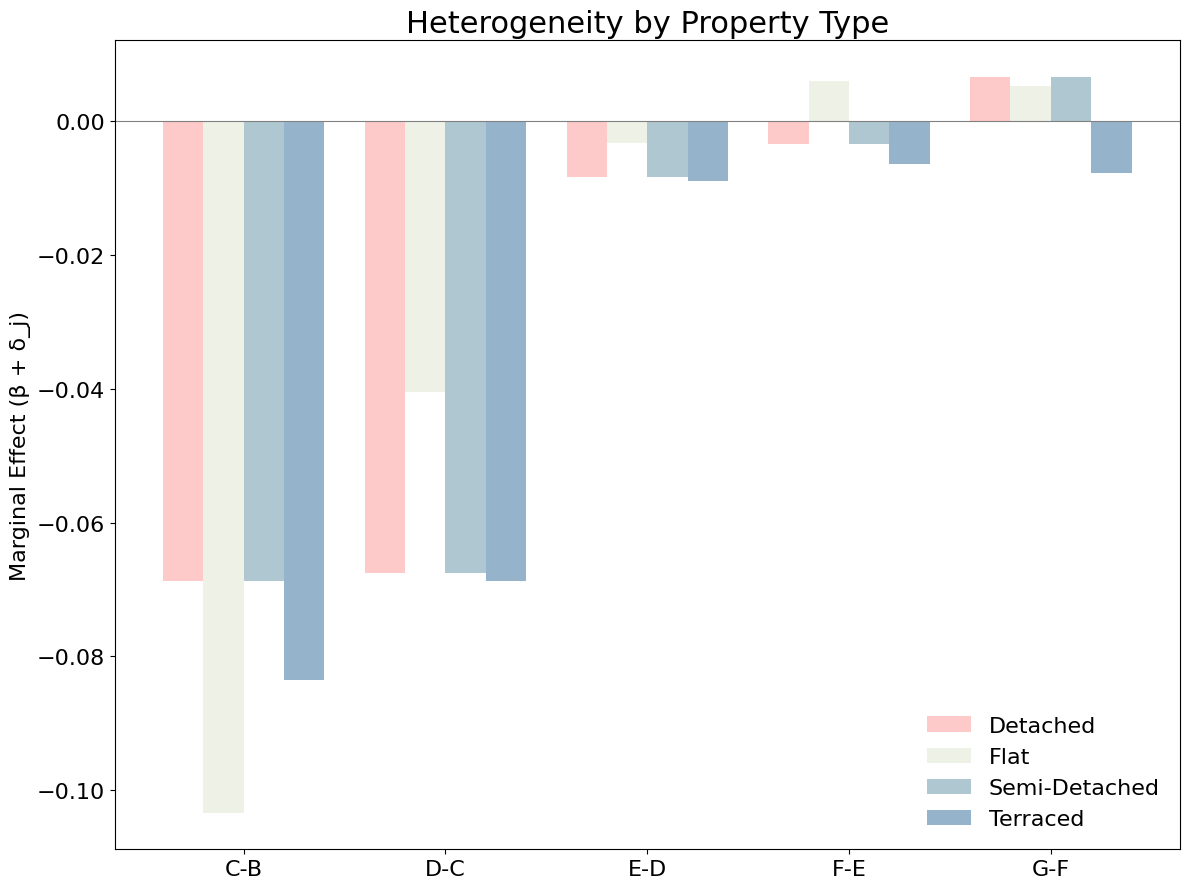

In [47]:
# Property types (assuming these are your categories)
property_types = ['Detached', 'Flat', 'Semi-Detached', 'Terraced']

# Prepare figure
fig, ax = plt.subplots(figsize=(12, 9))
results_df_cov = results_df_cov[results_df['Band'] != 'B-A']
bands = results_df_cov['Band'].tolist()
x = np.arange(len(bands))  # position for each band group
width = 0.2

# Bar offset for each property type
offsets = {
    'Detached': -1.5 * width,
    'Flat': -0.5 * width,
    'Semi-Detached': 0.5 * width,
    'Terraced': 1.5 * width,
}

colors = {
    'Detached': '#FEC9C9',
    'Flat': '#EEF1E6',
    'Semi-Detached': '#AFC7D0',
    'Terraced': '#95B4CC',
}

for ptype in property_types:
    effects = []
    for _, row in results_df_cov.iterrows():
        base = row['LPM_coef_cov']
        interaction_key = f'dist_to_threshold:C(property_type)[T.{ptype}]_coef'
        effect = base + row.get(interaction_key, 0)
        effects.append(effect)

    ax.bar(x + offsets[ptype], effects, width=width, label=ptype, color=colors[ptype])

# Formatting
ax.axhline(0, color='gray', linewidth=0.8)
ax.set_xticks(x)
ax.set_xticklabels(bands, fontsize = 16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Marginal Effect (β + δ_j)",fontsize=16)
ax.set_title("Heterogeneity by Property Type",fontsize=22)
ax.legend(frameon=False,fontsize=16)
plt.tight_layout()
plt.show()


##### Heterogeneity - Log of Prices

In [42]:
# Initialize results dictionary
summary_results_cov = []

for label, df_band in data_band_dict.items():
    # Drop missing values
    df_clean = df_band.dropna(subset=[
        'strategic_upgrade', 'dist_to_threshold', 'leasehold', 'co2_emissions_current',
        'total_floor_area', 'number_habitable_rooms', 'urban', 'sale_year', 'sale_quarter',
        'property_type', 'postcode_area', 'local_authority', 'region', 'prev_energy_rating_band'
    ])
    df_clean['price_group'] = pd.qcut(df_clean['price_log'], q=3, labels=['low', 'medium', 'high'])

    # Skip if not enough observations
    if len(df_clean) < 50:
        continue

    # Get metadata
    n_obs = len(df_clean)
    class_share = df_clean['strategic_upgrade'].mean()

    # === LPM ===
    formula = """
        strategic_upgrade ~ dist_to_threshold * C(price_group)"""
    #    + leasehold +total_floor_area + number_habitable_rooms + urban +  C(region)

    lpm_model = smf.ols(formula=formula, data=df_clean).fit()

    # Save base result
    result = {
        'Band': label,
        'N_obs': n_obs,
        'Class_Share': class_share,
        'dtt_coef_cov': lpm_model.params.get('dist_to_threshold', float('nan')),
        'dtt_pval_cov': lpm_model.pvalues.get('dist_to_threshold', float('nan')),
    }
    # Save interaction terms
    for param in lpm_model.params.index:
        if 'dist_to_threshold:C(price_group)' in param:
            result[f'{param}_coef'] = lpm_model.params[param]
            result[f'{param}_pval'] = lpm_model.pvalues[param]
    summary_results_cov.append(result)

# Convert to DataFrame for easy viewing
results_df_cov = pd.DataFrame(summary_results_cov)
results_df_cov = results_df_cov.sort_values('Band')
results_df_cov


<ipython-input-42-ceb83b27bad7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-42-ceb83b27bad7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-42-ceb83b27bad7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-42-ceb83b27ba

,Band,N_obs,Class_Share,dtt_coef_cov,dtt_pval_cov,dist_to_threshold:C(price_group)[T.medium]_coef,dist_to_threshold:C(price_group)[T.medium]_pval,dist_to_threshold:C(price_group)[T.high]_coef,dist_to_threshold:C(price_group)[T.high]_pval
5,B-A,147,0.149660,-0.153209,1.146198e-08,0.025533,0.436380,0.021521,0.548592
4,C-B,5255,0.302569,-0.092509,2.325254e-70,-0.006791,0.354977,-0.004098,0.577474
3,D-C,30644,0.404484,-0.063891,9.281777e-155,0.001829,0.591841,0.006556,0.053181
2,E-D,30025,0.237102,-0.009610,7.218192e-06,0.001558,0.607139,0.001357,0.652608
1,F-E,10244,0.121535,-0.005259,6.023754e-02,0.008630,0.031485,0.000564,0.887261
0,G-F,2356,0.067063,-0.006246,1.674930e-01,0.003762,0.549531,0.009579,0.133203


In [43]:
# Get quantile cutoffs in log(price)
low_cutoff_log = df_clean['price_log'].quantile(0.33)
high_cutoff_log = df_clean['price_log'].quantile(0.66)

# Convert to GBP
import numpy as np
low_cutoff_gbp = np.exp(low_cutoff_log)
high_cutoff_gbp = np.exp(high_cutoff_log)

# Format as rounded strings for labels
low_label = f"Low (< £{low_cutoff_gbp:,.0f})"
med_label = f"Medium (£{low_cutoff_gbp:,.0f}–£{high_cutoff_gbp:,.0f})"
high_label = f"High (> £{high_cutoff_gbp:,.0f})"

# Mapping for legend labels
legend_labels = {
    'low': low_label,
    'medium': med_label,
    'high': high_label
}


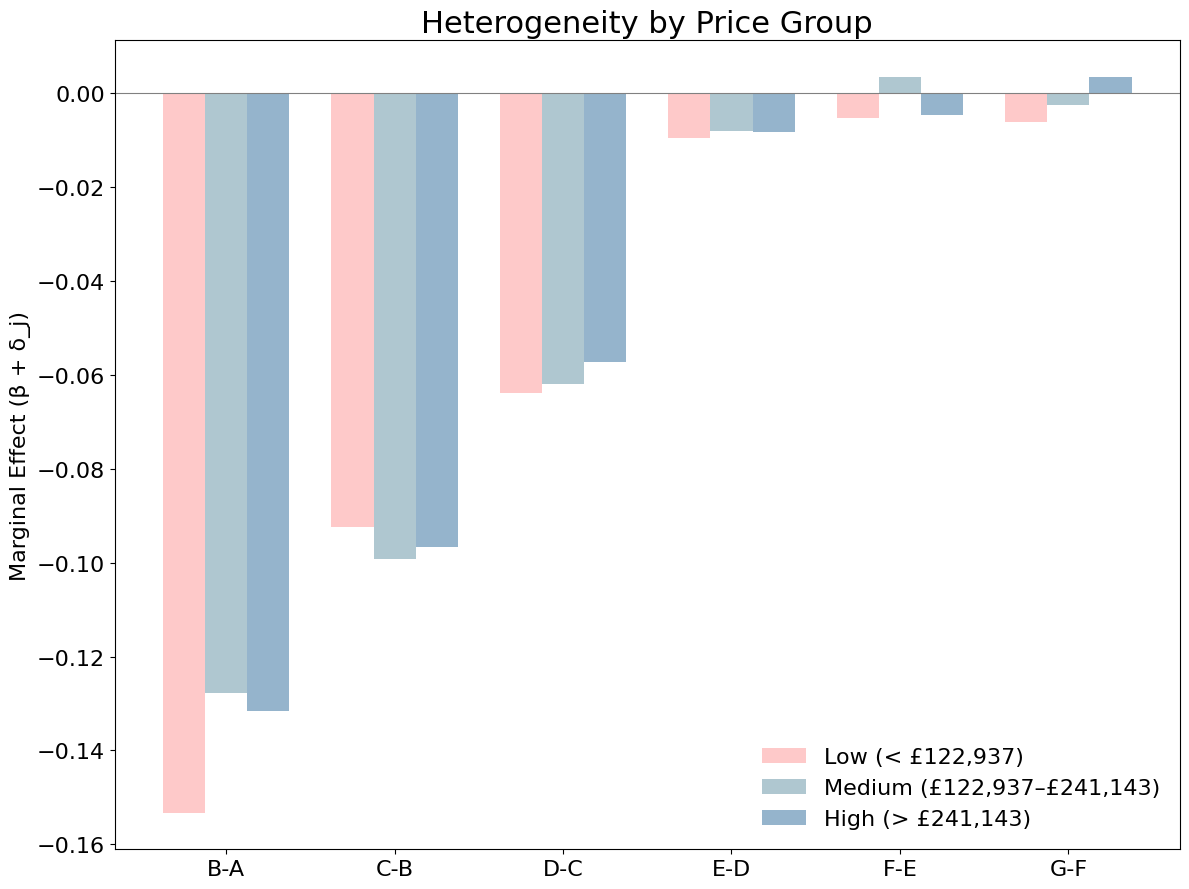

In [44]:
# Define your price groups and colors
price_groups = ['low', 'medium', 'high']
colors_price = {
    'low': '#FEC9C9',
    'medium': '#AFC7D0',
    'high': '#95B4CC'
}

# Prepare plot
fig, ax = plt.subplots(figsize=(12, 9))
bands = results_df_cov['Band'].tolist()
x = np.arange(len(bands))
width = 0.25

offsets = {
    'low': -width,
    'medium': 0,
    'high': width,
}

for group in price_groups:
    effects = []
    for _, row in results_df_cov.iterrows():
        base = row['dtt_coef_cov']
        interaction_key = f'dist_to_threshold:C(price_group)[T.{group}]_coef'
        delta = row.get(interaction_key, 0)
        effect = base + delta if group != 'low' else base  # 'low' is base group
        effects.append(effect)

    ax.bar(
    x + offsets[group],
    effects,
    width=width,
    label=legend_labels[group],  # use GBP range in legend
    color=colors_price[group]
)
# Plot formatting
ax.axhline(0, color='gray', linewidth=0.8)
ax.set_xticks(x)
ax.set_xticklabels(bands,fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Marginal Effect (β + δ_j)",fontsize=16)
ax.set_title("Heterogeneity by Price Group",fontsize=22)
ax.legend(frameon=False,fontsize=16)
plt.tight_layout()
plt.show()


#### Sensitivity - Upper

In [92]:
upper_bounds = [2,3,4,5,6,7,8,9,10]
sensitivity_upper_cov = []

for upper in upper_bounds:
    for label, cutoff in thresholds.items():
        df_band = df.copy()

        # Select observations near threshold
        mask_band_range = (
            (df_band['prev_energy_sap_rating'] >= cutoff - 5) &
            (df_band['prev_energy_sap_rating'] < cutoff)
        )
        df_band = df_band[mask_band_range].copy()

        # Define strategic upgrade
        df_band['strategic_upgrade'] = 0
        mask_strategic = (
            (df_band['energy_sap_rating'] >= cutoff) &
            (df_band['energy_sap_rating'] < cutoff + upper)
        )
        df_band.loc[mask_strategic, 'strategic_upgrade'] = 1

        # Define distance to threshold
        df_band['dist_to_threshold'] = cutoff - df_band['prev_energy_sap_rating']

        # Define regression formula
        formula = """
        strategic_upgrade ~ dist_to_threshold + leasehold +
        total_floor_area + number_habitable_rooms + urban +
        C(region)
        """

        # Fit regression
        model = smf.ols(formula=formula, data=df_band).fit()

        # Store result
        sensitivity_upper_cov.append({
            'Band': label,
            'UpperBound': upper,
            'Coef_dist_to_threshold': model.params['dist_to_threshold'],
            'Pval_dist_to_threshold': model.pvalues['dist_to_threshold']
        })

# Display as DataFrame
sensitivity_upper_cov_df = pd.DataFrame(sensitivity_upper_cov).round(4)
print("\n=== Sensitivity (With Covariates) - Varying Upper Bound ===")
sensitivity_upper_cov_df



=== Sensitivity (With Covariates) - Varying Upper Bound ===


,Band,UpperBound,Coef_dist_to_threshold,Pval_dist_to_threshold
0,G-F,2,-0.0008,0.8009
1,F-E,2,-0.0022,0.2508
2,E-D,2,-0.0050,0.0013
3,D-C,2,-0.0452,0.0000
4,C-B,2,-0.0992,0.0000
5,B-A,2,-0.1935,0.0001
6,G-F,3,-0.0003,0.9433
7,F-E,3,-0.0015,0.5261
8,E-D,3,-0.0060,0.0011
9,D-C,3,-0.0626,0.0000


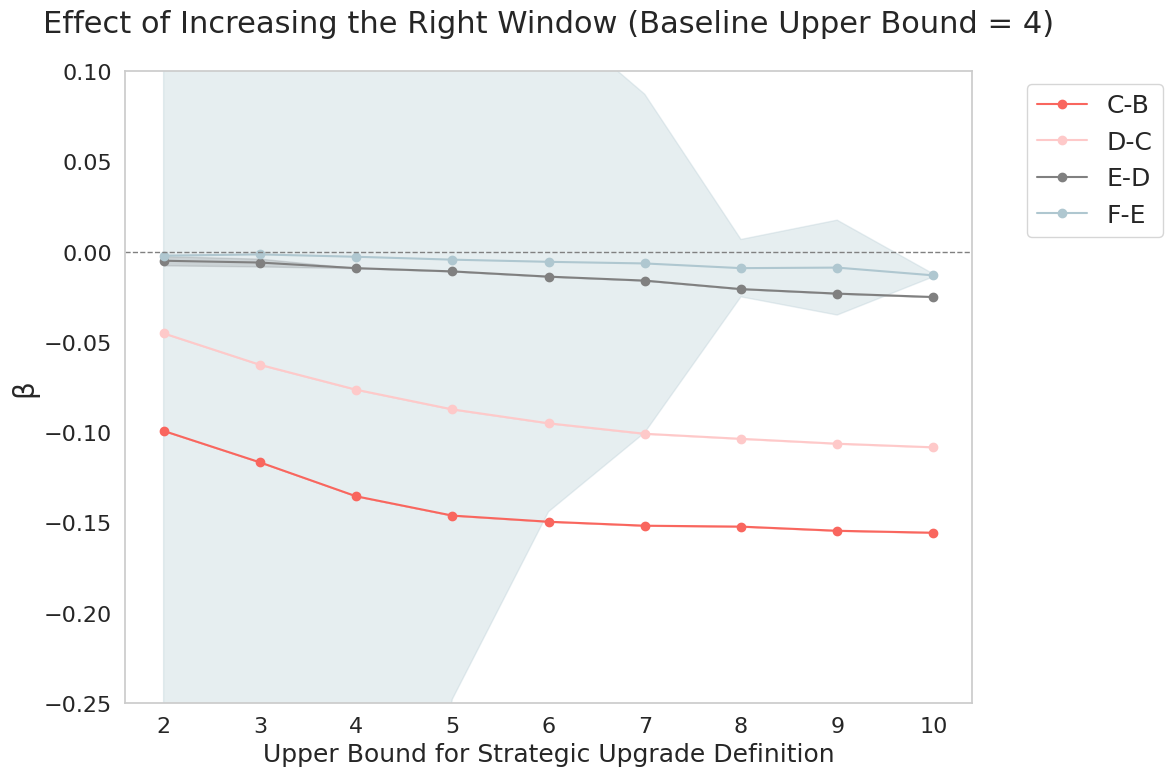

In [95]:
sns.set(style="whitegrid", font_scale=1.2)

# Initialize plot
plt.figure(figsize=(12, 8))

# Unique EPC bands

sensitivity_upper_cov_df = sensitivity_upper_cov_df[~sensitivity_upper_cov_df['Band'].isin(['G-F','B-A'])]
bands = sensitivity_upper_cov_df['Band'].unique()
colors = colors = ['#F9665E','#FEC9C9','GRAY','#AFC7D0','#95B4CC','#799FCB']

# Plot each band separately
for i, band in enumerate(sorted(bands)):
    df_band = sensitivity_upper_cov_df[sensitivity_upper_cov_df['Band'] == band].copy()
    df_band['UpperBound'] = df_band['UpperBound'].astype(int)

    # Compute confidence intervals (approximate 95%)
    df_band['ci_upper'] = df_band['Coef_dist_to_threshold'] + 1.96 * df_band['Pval_dist_to_threshold']  # using p-value as proxy for SE (not ideal, see note below)
    df_band['ci_lower'] = df_band['Coef_dist_to_threshold'] - 1.96 * df_band['Pval_dist_to_threshold']

    # Plot line
    plt.plot(
        df_band['UpperBound'],
        df_band['Coef_dist_to_threshold'],
        label=band,
        color=colors[i],
        marker='o'
    )

    # Add error bars (scatter + CI)
    plt.fill_between(
        df_band['UpperBound'],
        df_band['ci_lower'],
        df_band['ci_upper'],
        color=colors[i],
        alpha=0.3
    )

# Final formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Upper Bound for Strategic Upgrade Definition", fontsize = 18)
plt.ylabel("β", fontsize = 20)
plt.title("Effect of Increasing the Right Window (Baseline Upper Bound = 4)", fontsize = 22, pad = 28)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 18)
plt.ylim(-0.25,0.1)
plt.xticks(fontsize=16)  # Adjust x-axis tick label font size
plt.yticks(fontsize=16)
plt.tight_layout()
plt.grid()
plt.show()


#### Sensitivity - Lower Bound

In [82]:
lower_bounds = [2,3,4,5,6,7,8,9,10]  # corresponds to -5, -7, -9, -11
sensitivity_lower_cov = []

for lower in lower_bounds:
    for label, cutoff in thresholds.items():
        df_band = df.copy()

        # Select observations near threshold
        mask_band_range = (
            (df_band['prev_energy_sap_rating'] >= cutoff - lower) &
            (df_band['prev_energy_sap_rating'] < cutoff)
        )
        df_band = df_band[mask_band_range].copy()

        # Define strategic upgrade
        df_band['strategic_upgrade'] = 0
        mask_strategic = (
            (df_band['energy_sap_rating'] >= cutoff) &
            (df_band['energy_sap_rating'] < cutoff + 3)
        )
        df_band.loc[mask_strategic, 'strategic_upgrade'] = 1

        # Define distance to threshold
        df_band['dist_to_threshold'] = cutoff - df_band['prev_energy_sap_rating']

        # Define regression formula
        ormula = """
        strategic_upgrade ~ dist_to_threshold + leasehold +
        total_floor_area + number_habitable_rooms + urban +
        C(region)
        """

        # Fit regression
        model = smf.ols(formula=formula, data=df_band).fit()

        # Store result
        sensitivity_lower_cov.append({
            'Band': label,
            'LowerBound': -lower,
            'Coef_dist_to_threshold': model.params['dist_to_threshold'],
            'Pval_dist_to_threshold': model.pvalues['dist_to_threshold']
        })

# Display as DataFrame
sensitivity_lower_cov_df = pd.DataFrame(sensitivity_lower_cov).round(4)
print("\n=== Sensitivity (With Covariates) - Varying Lower Bound ===")
sensitivity_lower_cov_df



=== Sensitivity (With Covariates) - Varying Lower Bound ===


,Band,LowerBound,Coef_dist_to_threshold,Pval_dist_to_threshold
0,G-F,-2,-0.0042,0.7953
1,F-E,-2,-0.0256,0.0073
2,E-D,-2,-0.0043,0.5944
3,D-C,-2,-0.0918,0.0000
4,C-B,-2,-0.2766,0.0000
5,B-A,-2,-0.2385,0.0443
6,G-F,-3,-0.0144,0.0647
7,F-E,-3,-0.0045,0.3581
8,E-D,-3,-0.0056,0.1656
9,D-C,-3,-0.0843,0.0000


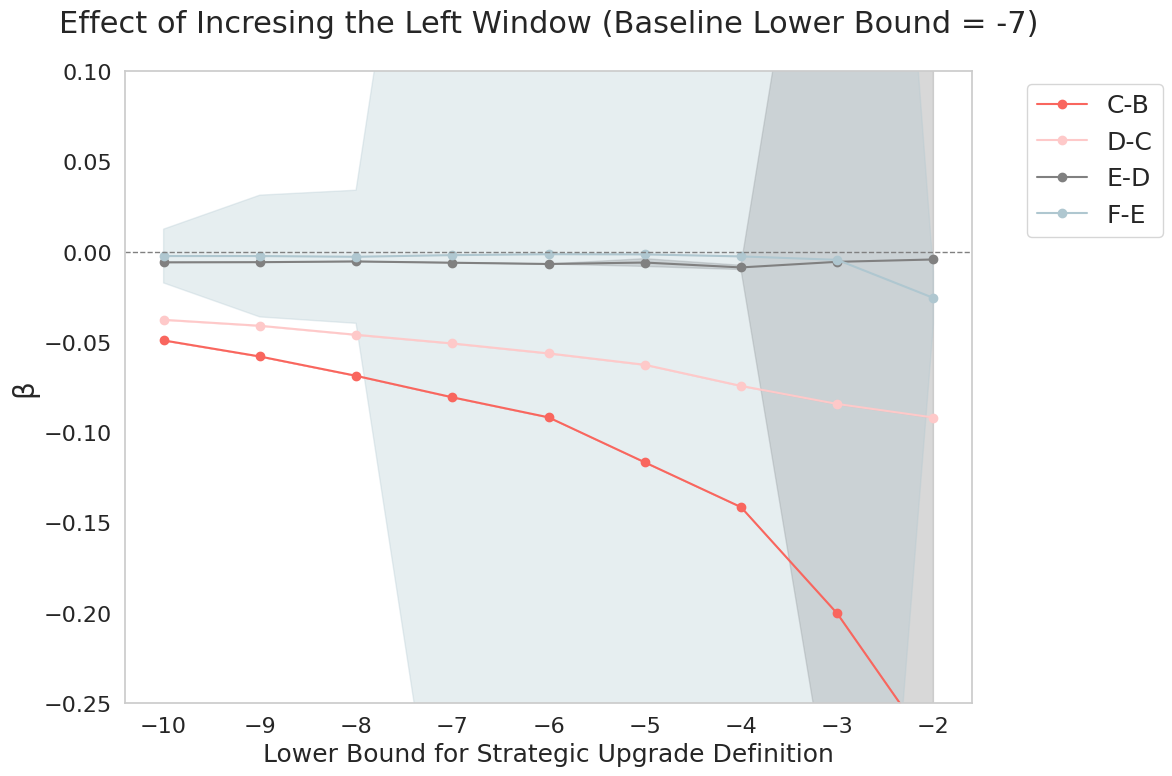

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set consistent style
sns.set(style="whitegrid", font_scale=1.2)

# Initialize plot
plt.figure(figsize=(12, 8))

# Unique EPC bands
sensitivity_lower_cov_df = sensitivity_lower_cov_df[~sensitivity_lower_cov_df['Band'].isin(['G-F','B-A'])]
bands = sensitivity_lower_cov_df['Band'].unique()
colors = colors = ['#F9665E','#FEC9C9','GRAY','#AFC7D0','#95B4CC','#799FCB']

# Plot each band separately
for i, band in enumerate(sorted(bands)):
    df_band = sensitivity_lower_cov_df[sensitivity_lower_cov_df['Band'] == band].copy()
    df_band['LowerBound'] = df_band['LowerBound'].astype(int)

    # Compute confidence intervals (approximate 95%)
    df_band['ci_upper'] = df_band['Coef_dist_to_threshold'] + 1.96 * df_band['Pval_dist_to_threshold']  # using p-value as proxy for SE (not ideal, see note below)
    df_band['ci_lower'] = df_band['Coef_dist_to_threshold'] - 1.96 * df_band['Pval_dist_to_threshold']

    # Plot line
    plt.plot(
        df_band['LowerBound'],
        df_band['Coef_dist_to_threshold'],
        label=band,
        color=colors[i],
        marker='o'
    )

    # Add error bars (scatter + CI)
    plt.fill_between(
        df_band['LowerBound'],
        df_band['ci_lower'],
        df_band['ci_upper'],
        color=colors[i],
        alpha=0.3
    )

# Final formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Lower Bound for Strategic Upgrade Definition", fontsize = 18)
plt.ylabel("β", fontsize = 20)
plt.title("Effect of Incresing the Left Window (Baseline Lower Bound = -7)", fontsize = 22, pad = 28)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 18)
plt.ylim(-0.25,0.1)
plt.xticks(fontsize=16)  # Adjust x-axis tick label font size
plt.yticks(fontsize=16)
plt.tight_layout()
plt.grid()
plt.show()
